# SHARENOW pickup location distribution

Credit for model to https://github.com/DanieleGammelli/pyro-torch-normalizing-flows

In [ ]:
import pyro
import torch
from torch import nn
from pyro.infer import SVI, Trace_ELBO
from torch.optim import Adam

import tqdm
import itertools
import numpy as np
import matplotlib.pyplot as plt
import math

from models.conditional_affine_coupling_nf import ConditionalNormalizingFlow

import pandas as pd
from sklearn import preprocessing
import time as time
from random import sample
from scipy.stats import kde
import seaborn as sns
from IPython.display import clear_output

In [2]:
plt.style.use("ggplot")
%matplotlib inline

### Data 

In [3]:
data = pd.read_csv('data_clean_dist.csv', sep = ',')

In [4]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(Dataset, self).__init__()
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.X[idx], self.y[idx]

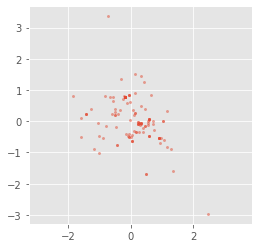

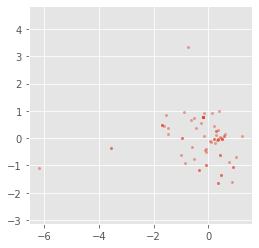

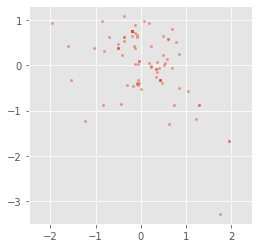

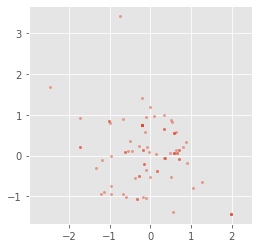

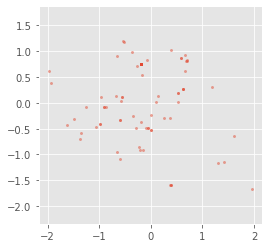

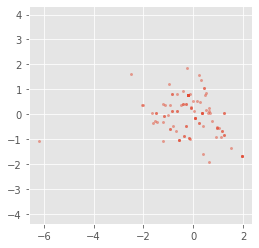

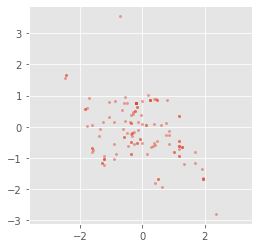

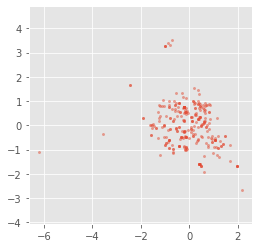

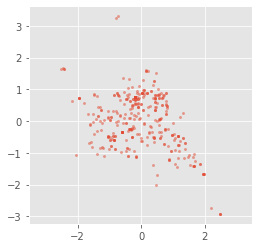

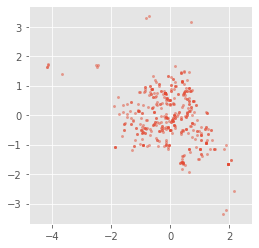

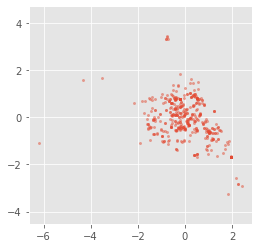

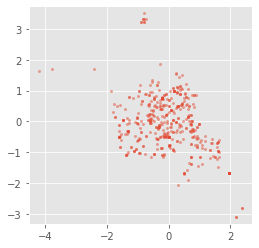

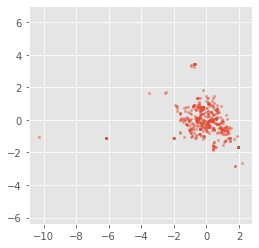

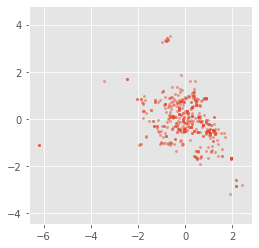

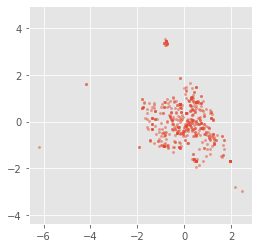

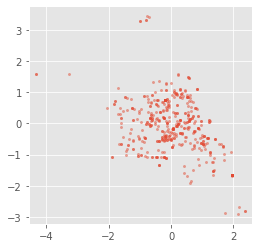

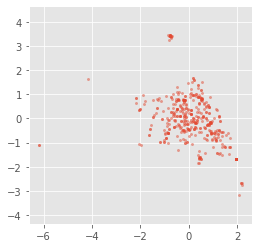

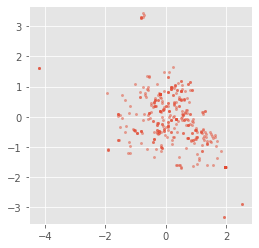

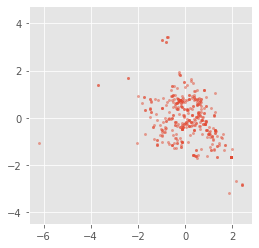

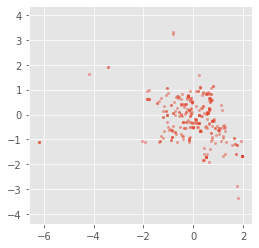

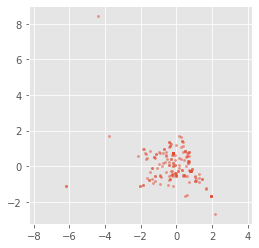

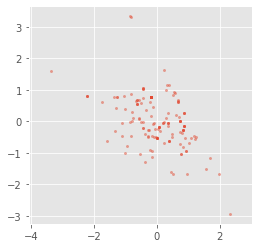

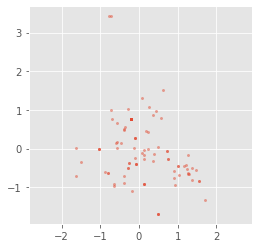

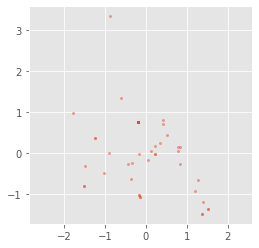

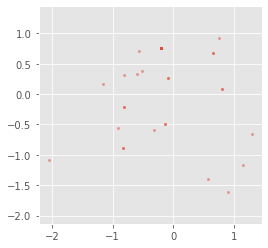

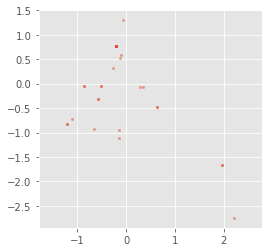

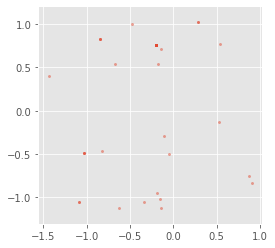

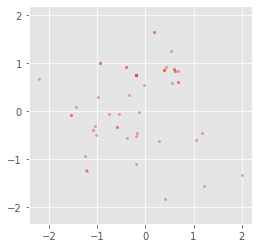

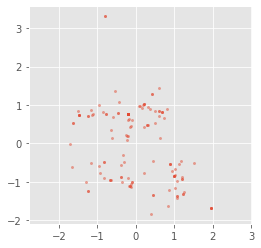

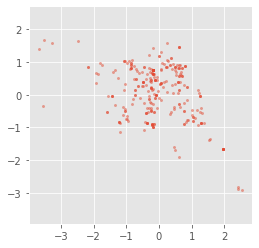

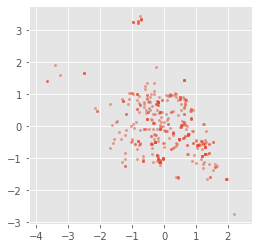

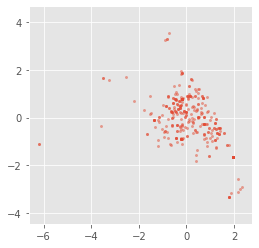

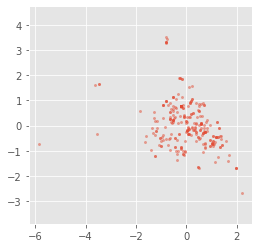

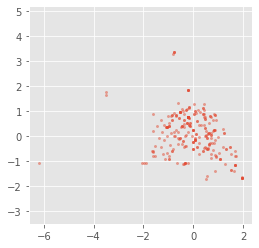

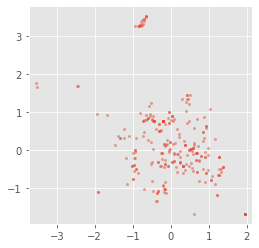

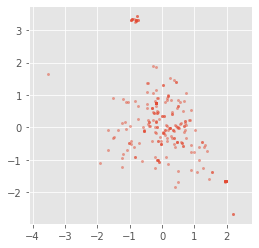

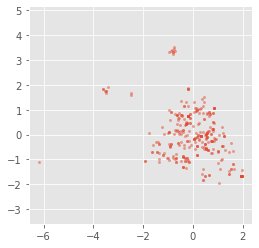

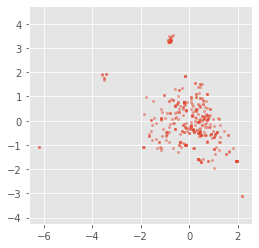

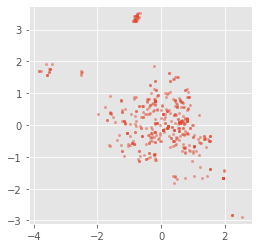

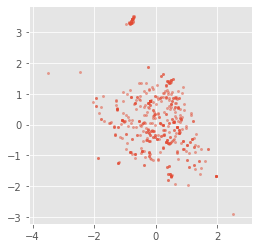

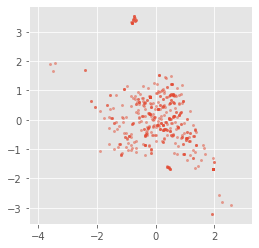

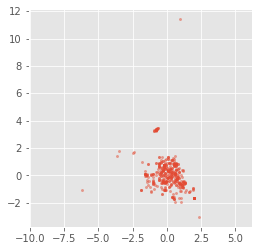

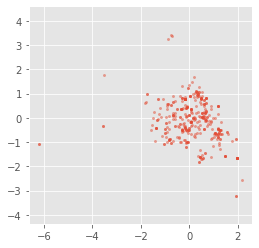

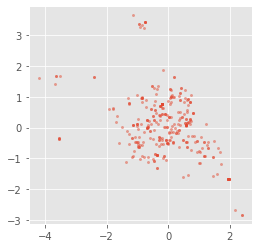

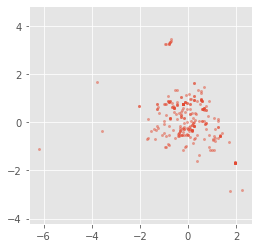

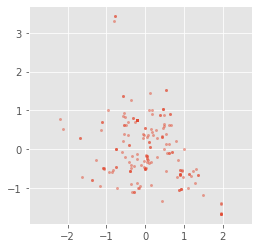

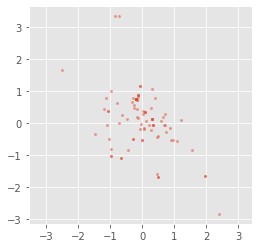

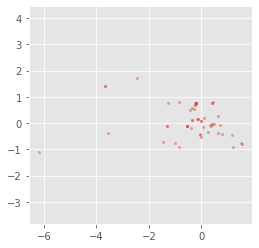

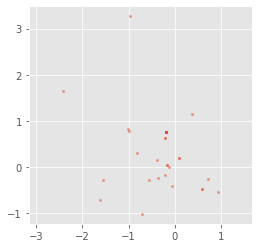

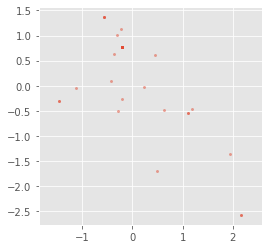

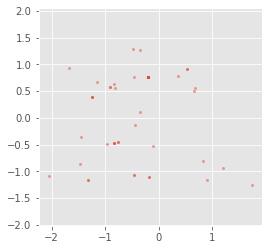

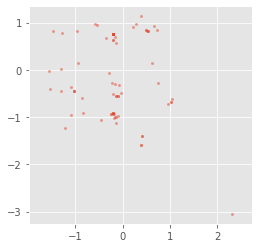

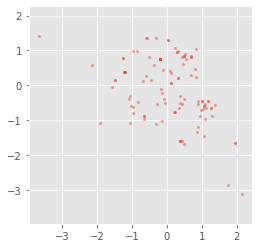

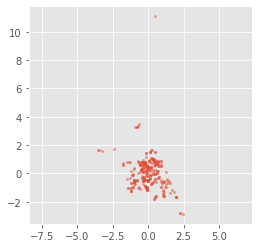

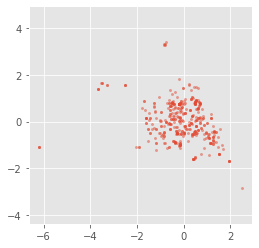

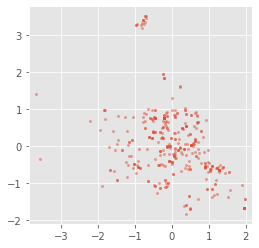

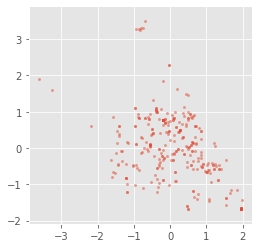

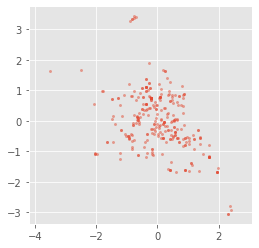

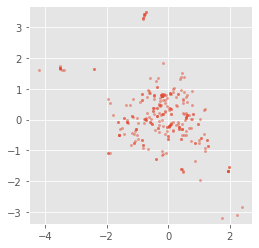

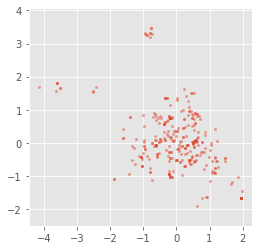

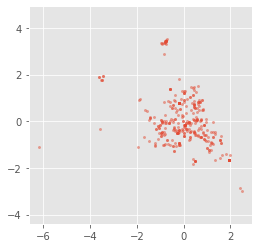

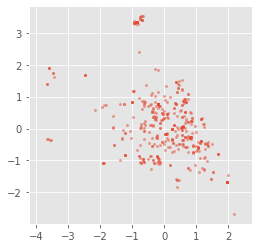

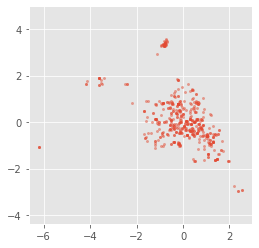

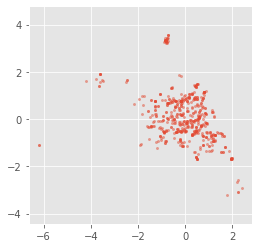

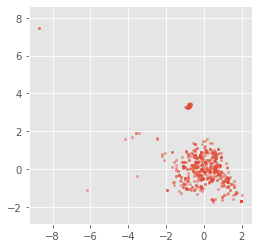

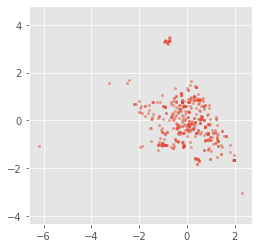

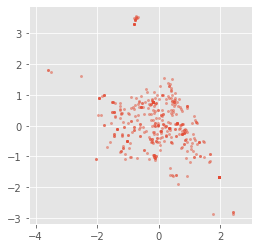

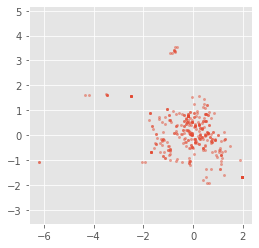

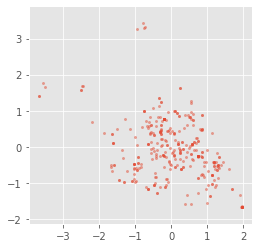

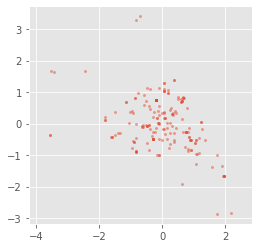

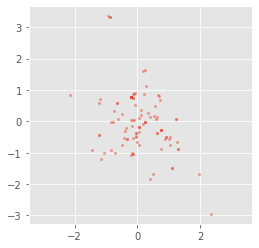

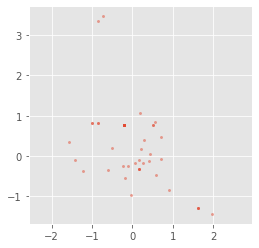

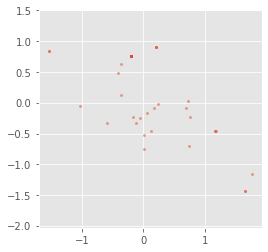

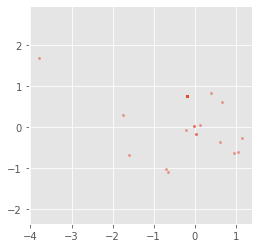

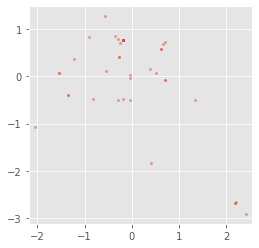

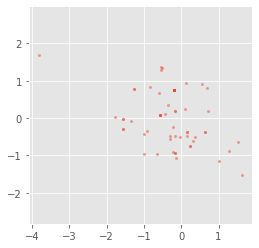

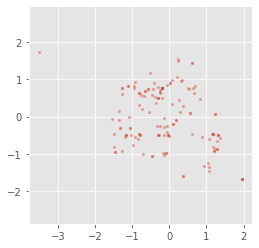

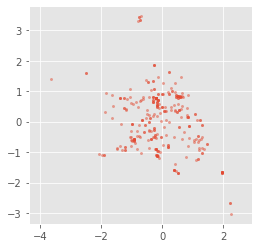

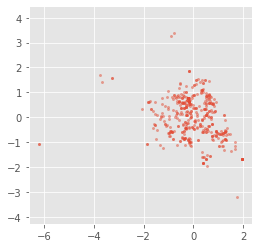

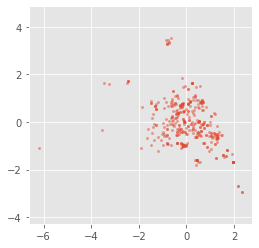

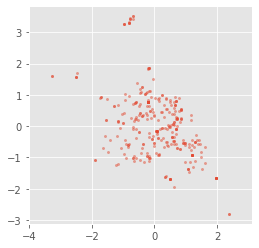

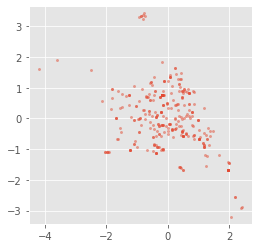

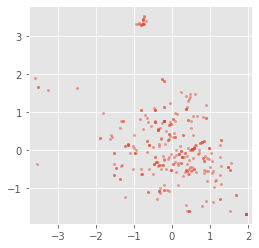

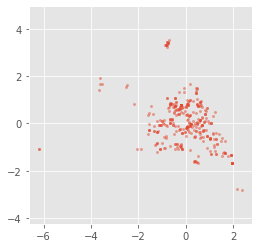

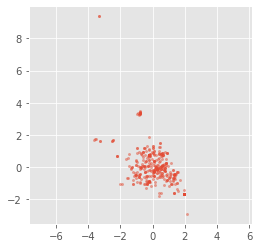

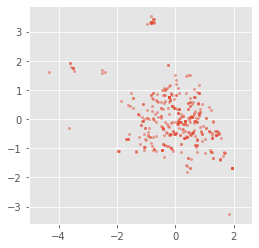

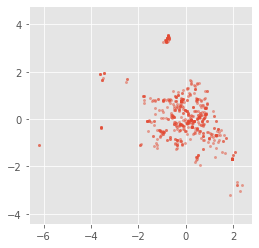

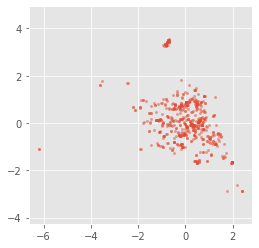

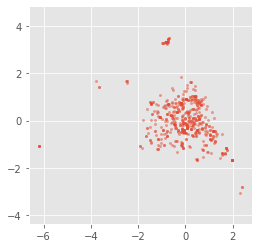

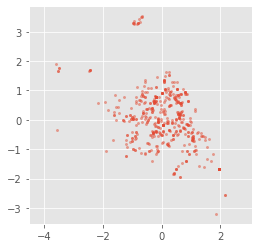

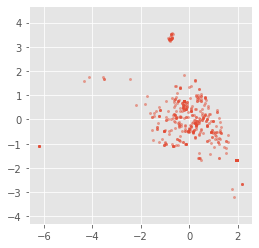

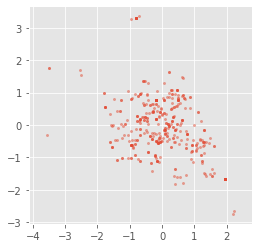

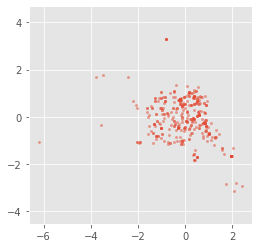

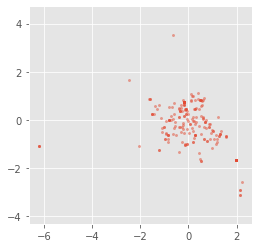

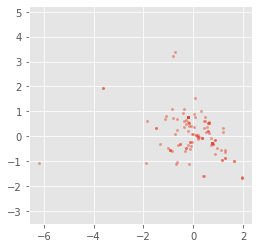

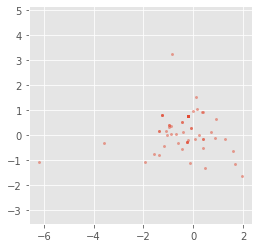

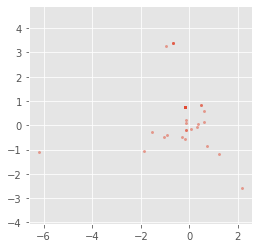

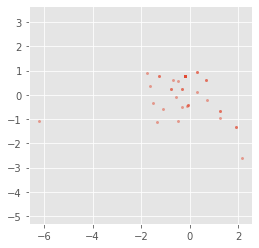

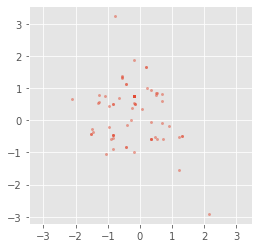

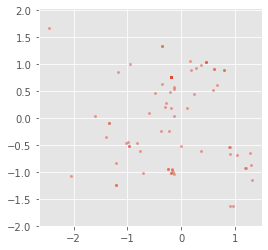

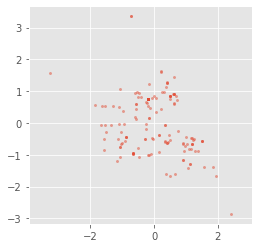

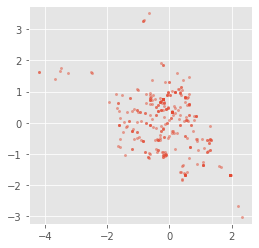

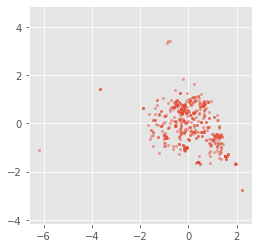

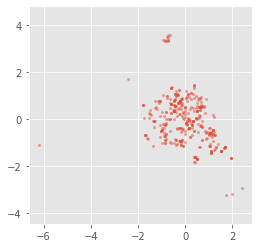

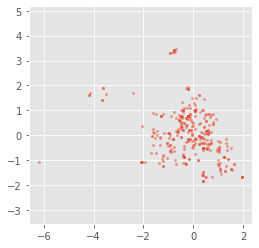

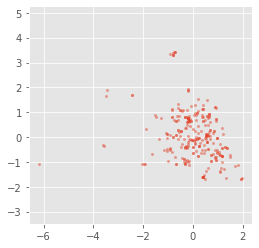

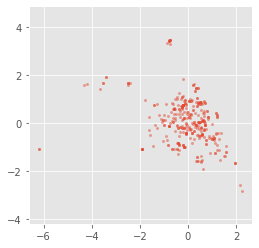

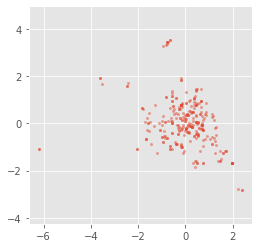

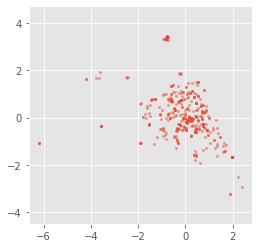

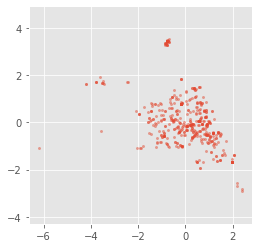

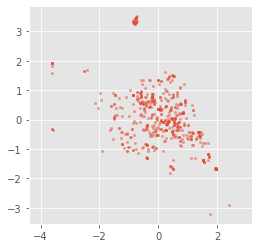

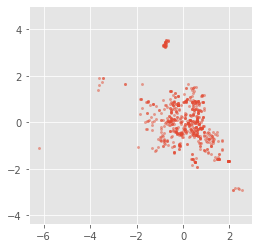

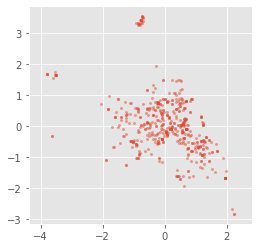

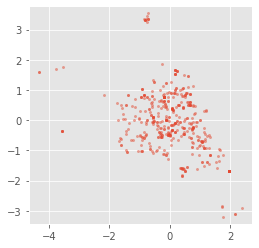

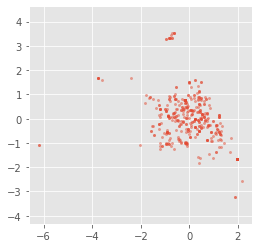

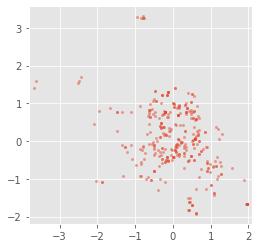

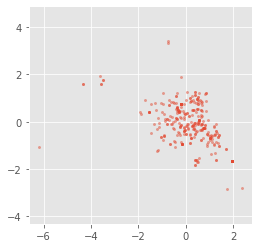

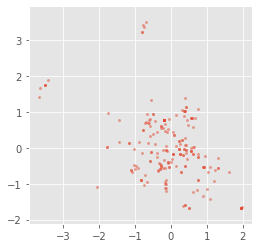

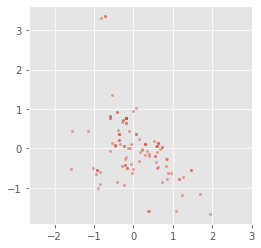

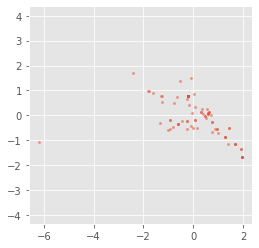

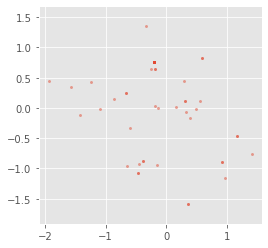

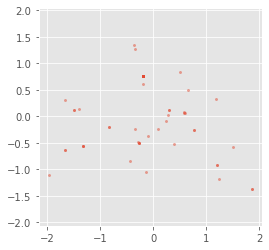

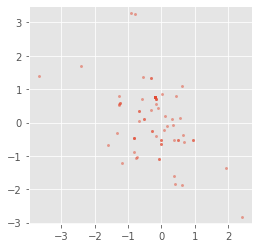

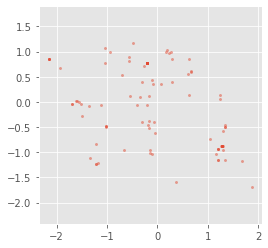

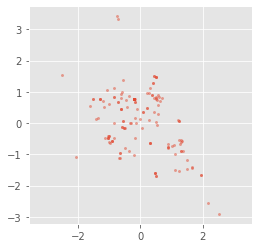

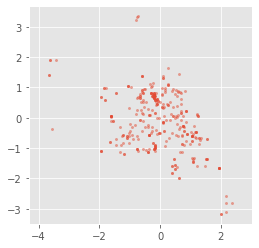

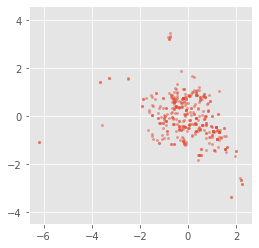

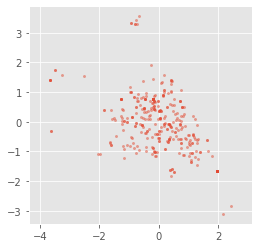

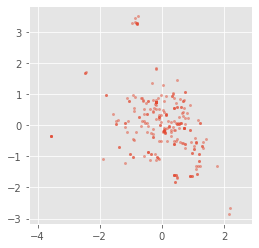

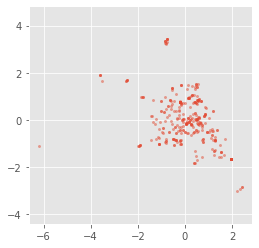

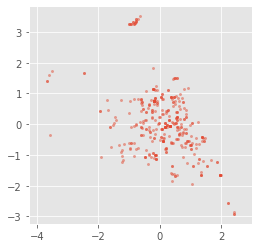

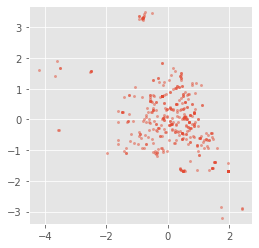

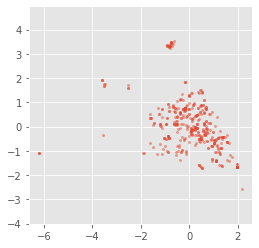

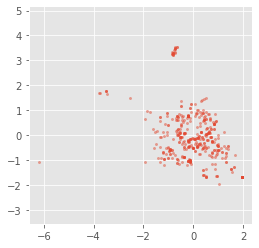

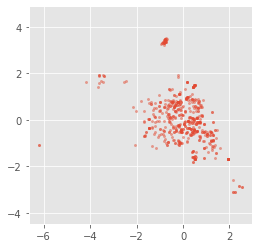

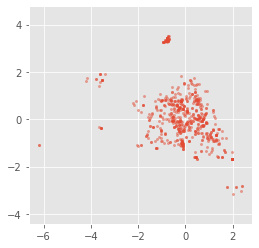

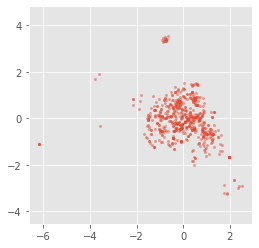

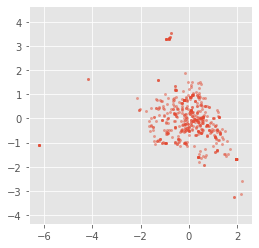

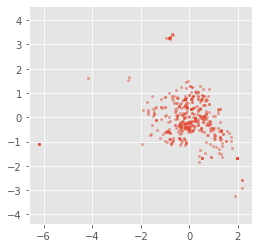

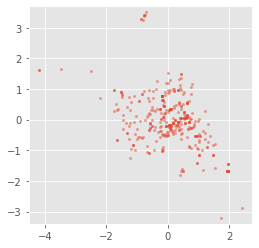

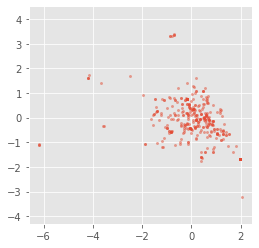

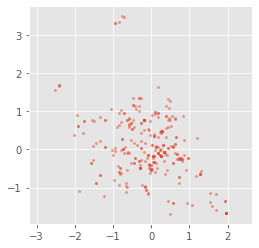

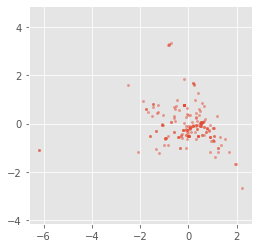

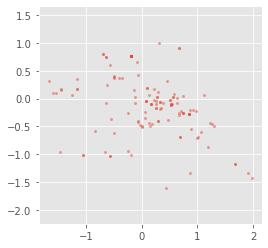

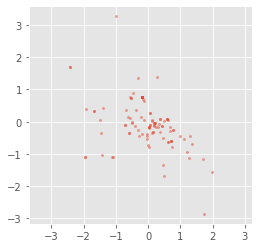

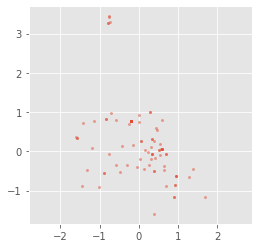

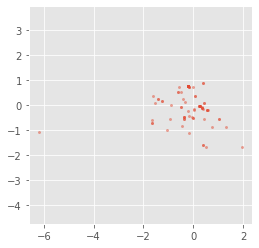

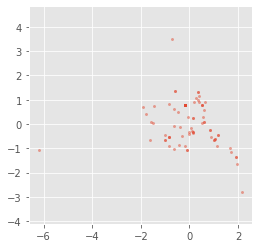

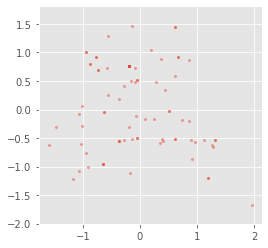

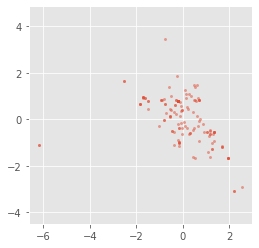

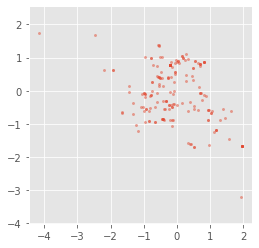

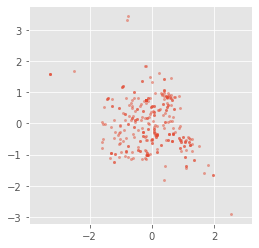

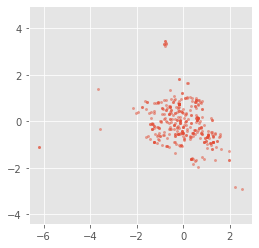

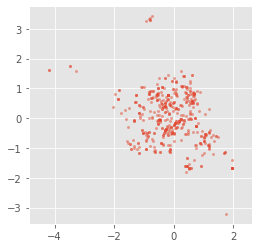

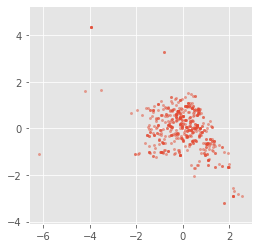

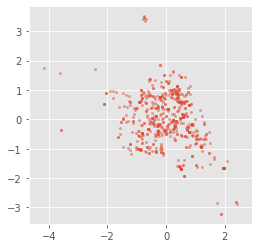

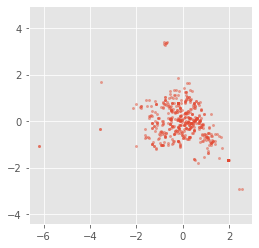

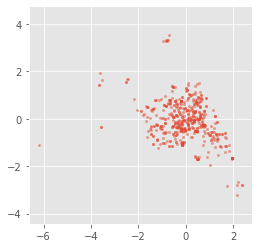

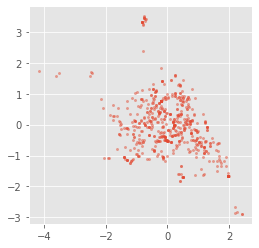

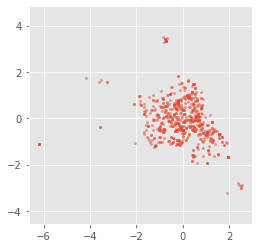

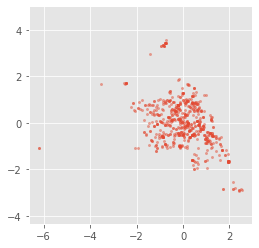

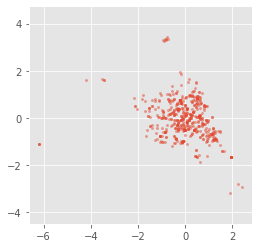

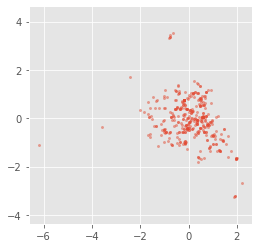

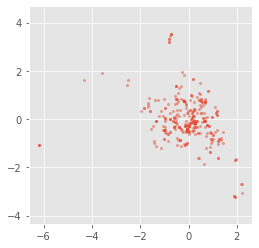

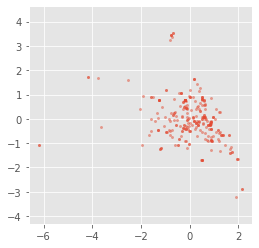

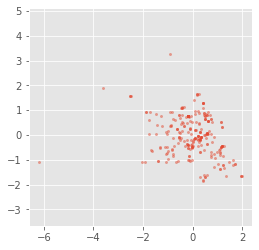

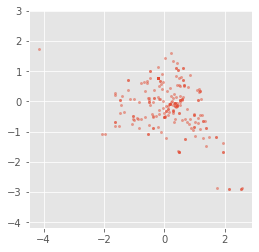

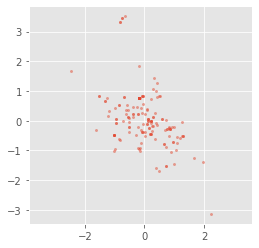

In [6]:
data = pd.read_csv('data_clean.csv', sep = ',')
data = data[['Start tidspunkt', 'Latitude (Start)', 'Longitude (Start)']]
weekday = np.zeros(len(data['Start tidspunkt']))
dayhour = np.zeros(len(data['Start tidspunkt']))

for i in range(len(data['Start tidspunkt'])):
    weekday[i] = time.strftime('%w', time.gmtime(data['Start tidspunkt'][i]))
    dayhour[i] = time.strftime('%H', time.gmtime(data['Start tidspunkt'][i]))
#weekday = weekday.astype(np.int)

data['Weekhour'] = weekday*24 + dayhour

data_tensor = torch.tensor(data.values, dtype=torch.float)
randin = torch.randint(len(data_tensor), (50000,))
mean, sd = [torch.mean(data_tensor[randin,1:3],0), np.sqrt(torch.var(data_tensor[randin,1:3],0))]
X_real = data_tensor[randin,1:3]
X_H = preprocessing.scale(X_real)
X_H = torch.tensor(X_H, dtype=torch.float)
H = data_tensor[randin,3]
H = H.unsqueeze(-1)
dataset = Dataset(H, X_H)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=200,
                      shuffle=True, num_workers=0)
#idx = []
for i in range(7*24):
    plt.figure(figsize=(4,4))
    idx = np.argwhere(np.asarray(H == i))
    #idx.append(idx)
    # sns.kdeplot(x=x[:,0], y=x[:,1], n_levels=100, 
    #             thresh=0, fill=True, levels=100, cmap="mako")
    plt.scatter(X_H[idx,1], X_H[idx,0], s=5, alpha=0.5)
    plt.axis('equal')
    plt.show()

### Conditional normalizing flow 

In [7]:
# Build NF model
cnf = ConditionalNormalizingFlow(input_dim=2, split_dim=1, context_dim=1, hidden_dim=24, num_layers=5, flow_length=10, 
                    use_cuda=False)

In [8]:
# Build SVI object
optimizer = pyro.optim.Adam({"lr": 0.0001})
svi = SVI(cnf.model, cnf.guide, optimizer, Trace_ELBO(num_particles=1))

In [9]:
print("number of params: ", sum(p.numel() for p in nn.ModuleList(cnf.transforms).parameters()))

number of params:  25220


In [139]:
num_epochs = 300
losses = []
pyro.clear_param_store()
epochs = tqdm.trange(num_epochs)

for epoch in epochs:
    try:
        running_loss = 0
        for x_batch, y_batch in dataloader:
            if cnf.use_cuda:
                y_batch, x_batch = y_batch.cuda(), x_batch.cuda()
            loss = svi.step(y_batch, x_batch)
            running_loss += float(loss)
            del x_batch, y_batch
            del loss
        losses.append(running_loss)
        epochs.set_description("ELBO: {:.2f}".format(running_loss))
        del running_loss
    except KeyboardInterrupt:
        plt.plot(losses);
        break

ELBO: 111341.85: 100%|██████████| 300/300 [35:21<00:00,  7.07s/it]


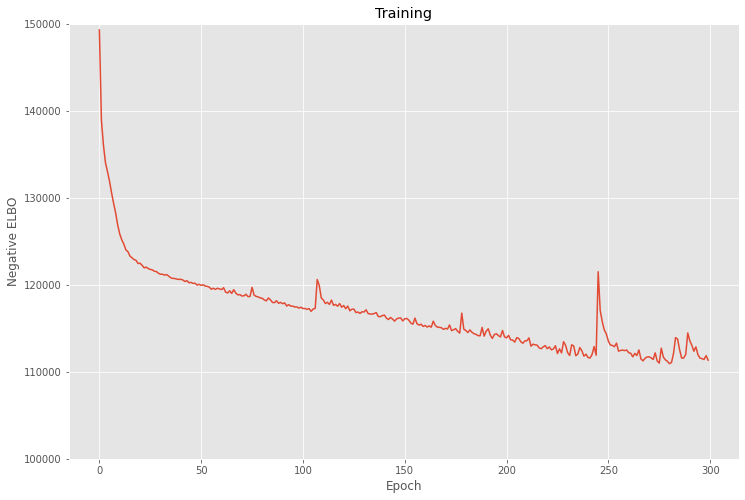

In [143]:
torch.save(cnf, "cnf_torch_save_run_last")
plt.figure(figsize=(12, 8))
plt.plot(losses)
plt.ylim((100000,150000))
plt.ylabel('Negative ELBO')
plt.xlabel('Epoch')
plt.title('Training')
plt.savefig('training_plot.pdf')
plt.show()

In [10]:
cnf = torch.load("cnf_torch_save_run_last")

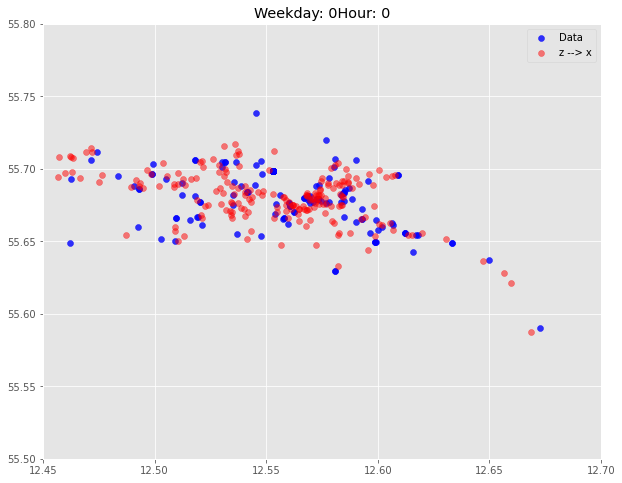

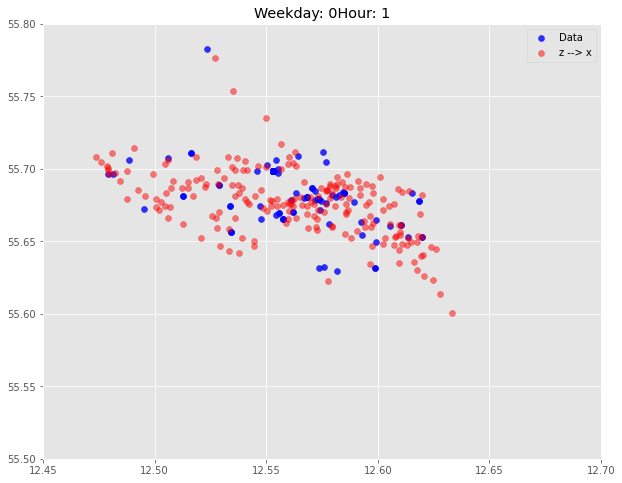

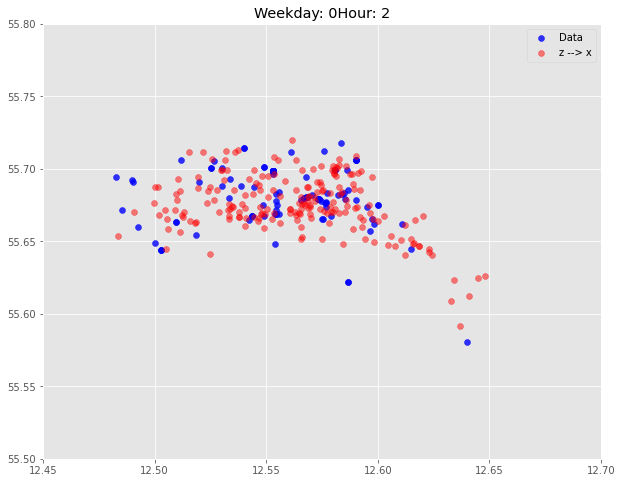

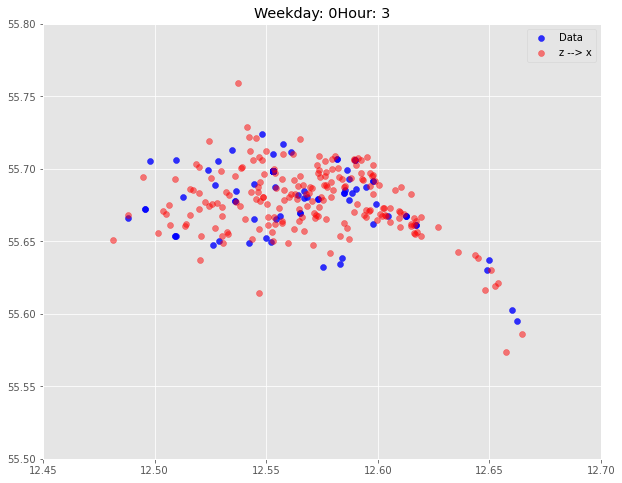

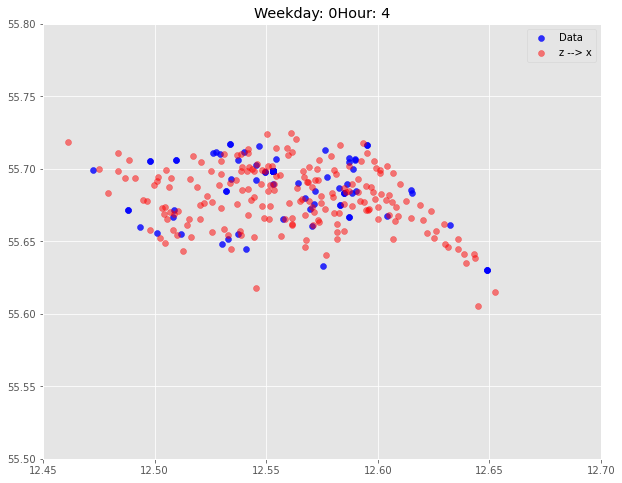

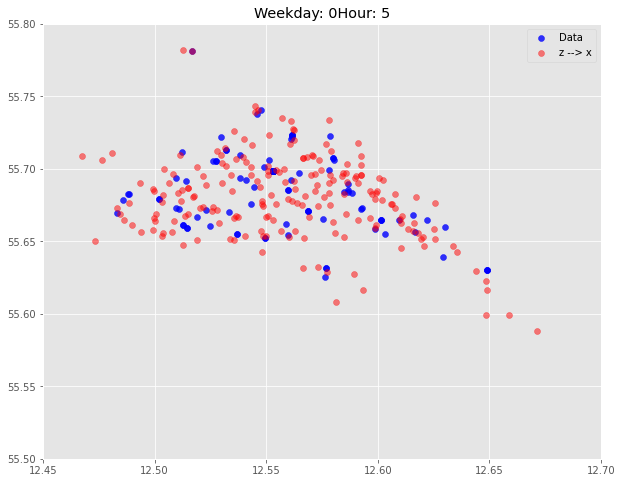

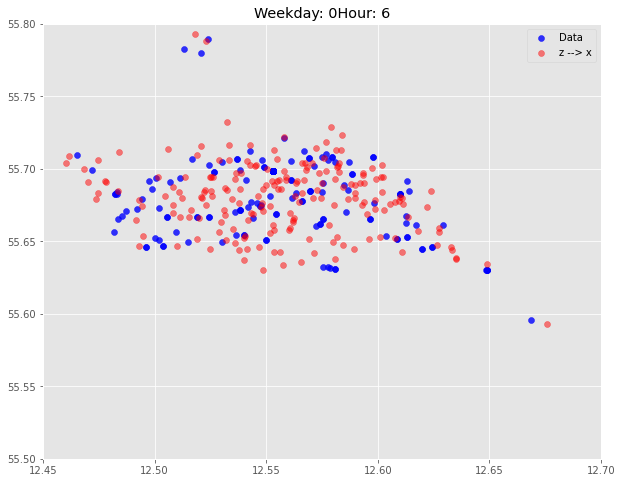

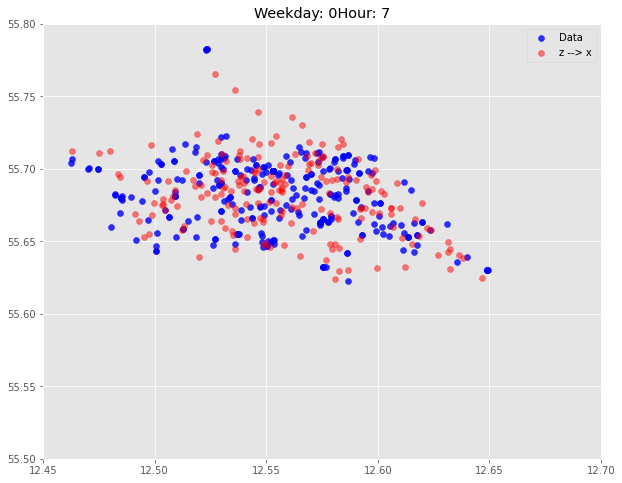

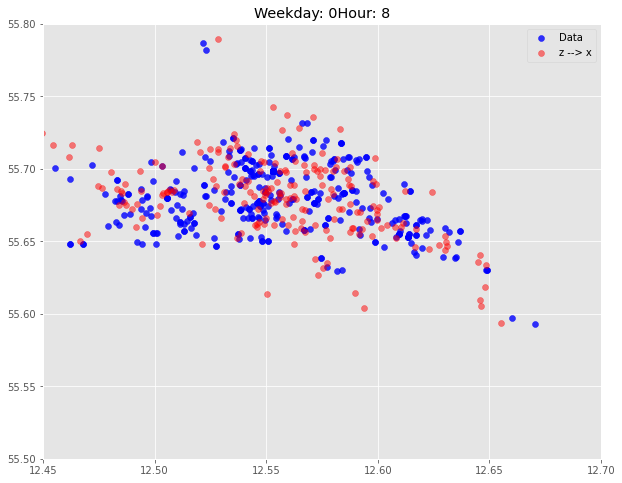

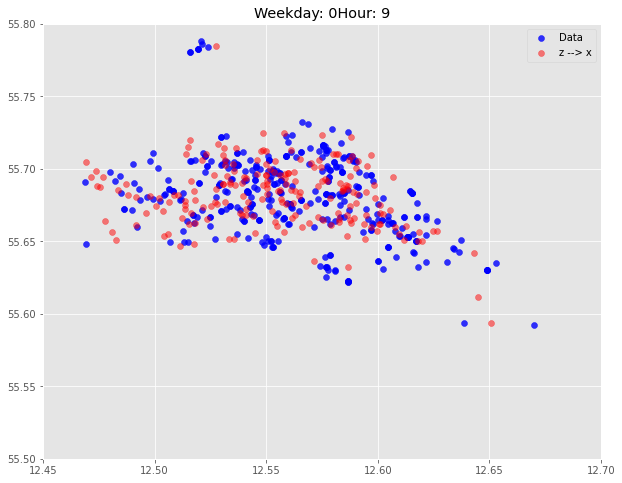

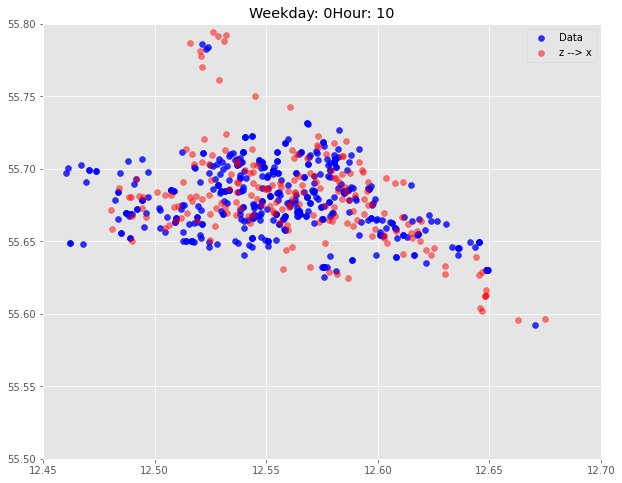

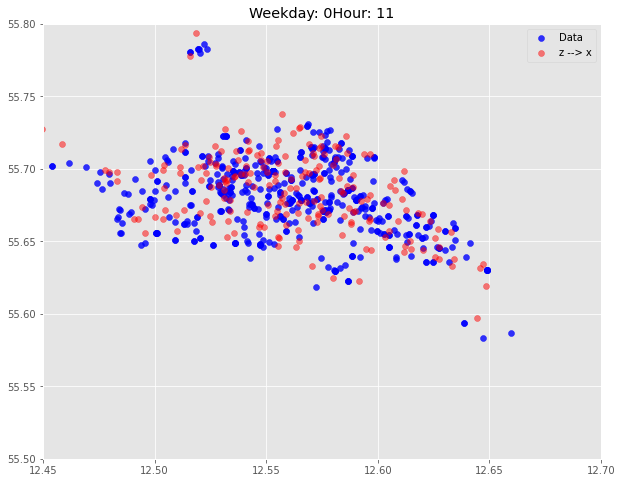

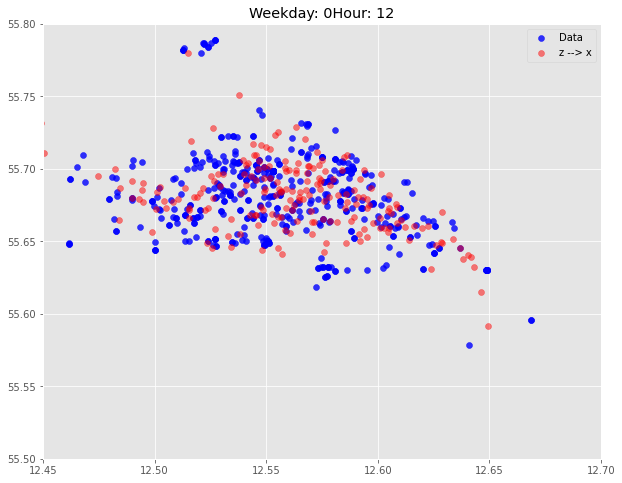

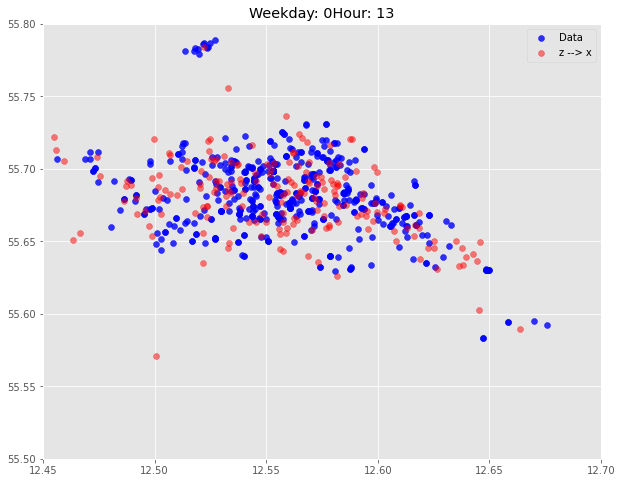

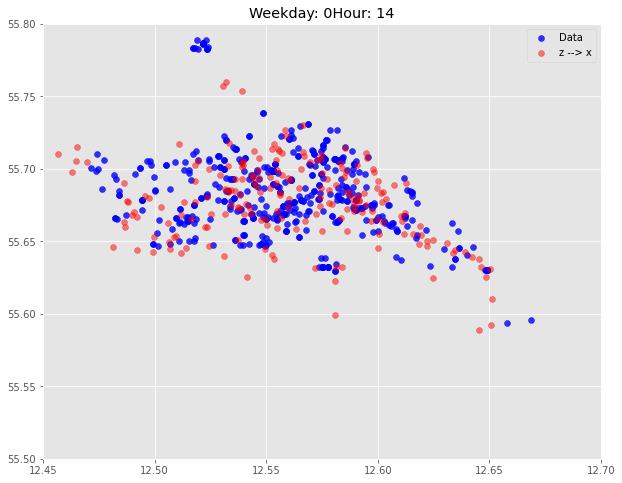

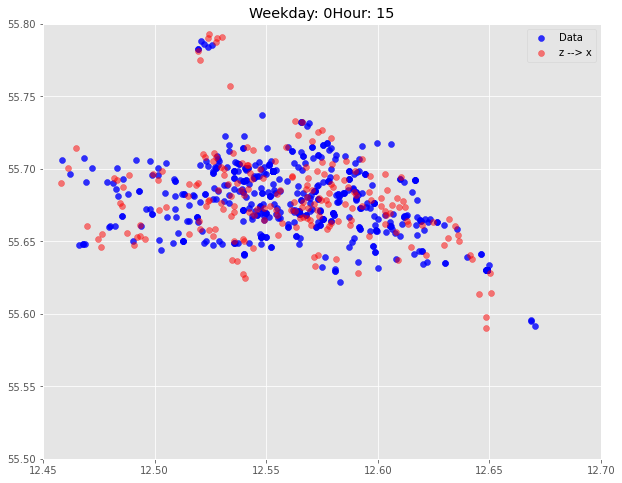

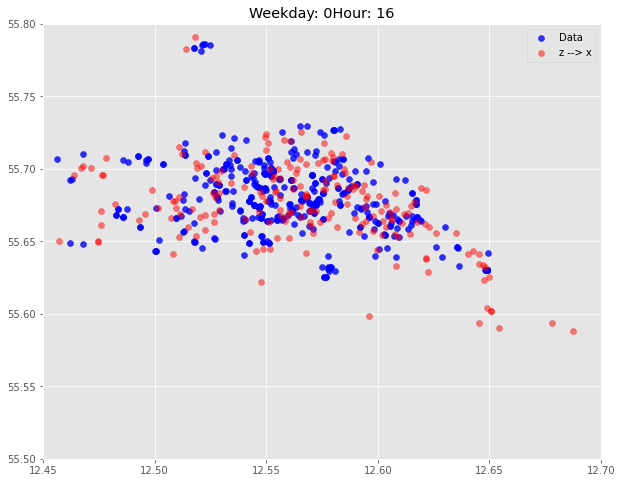

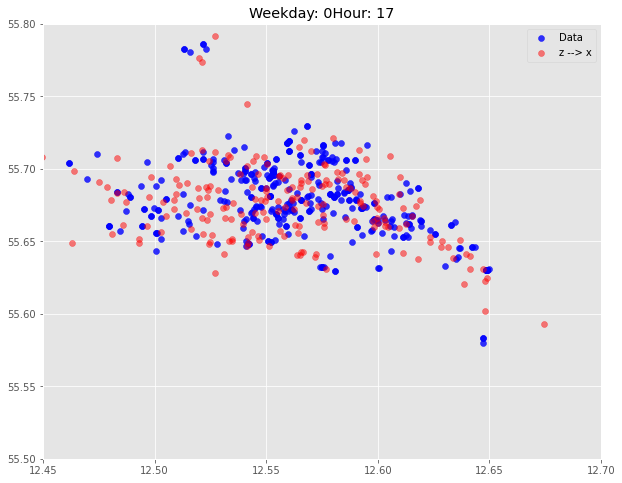

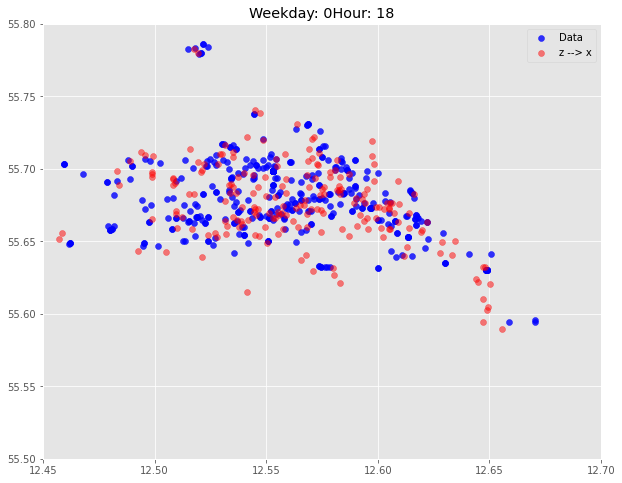

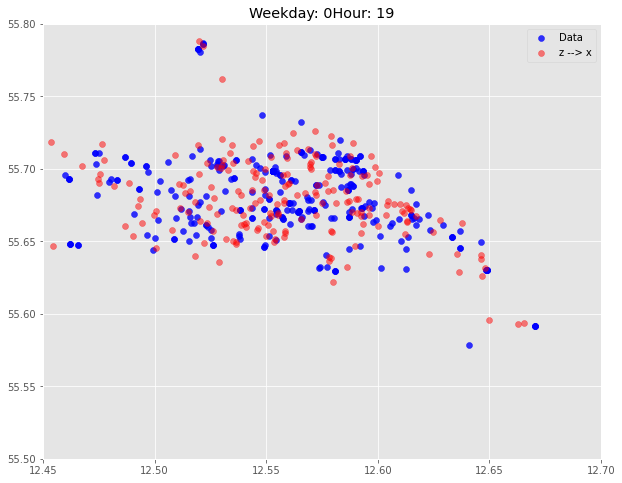

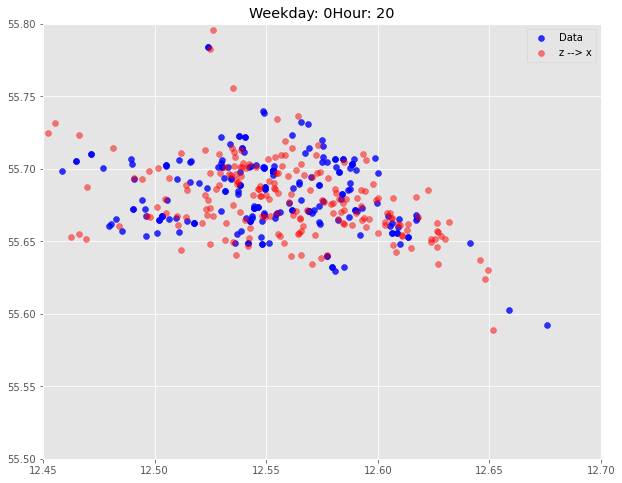

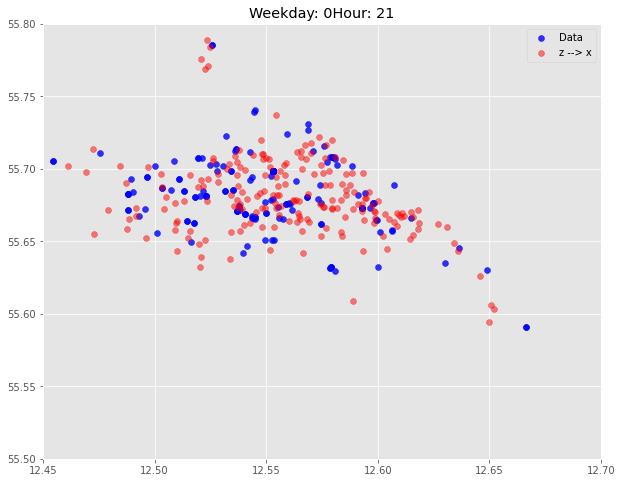

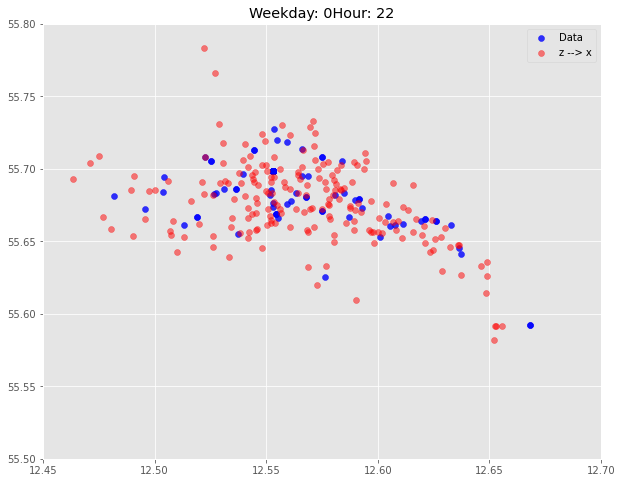

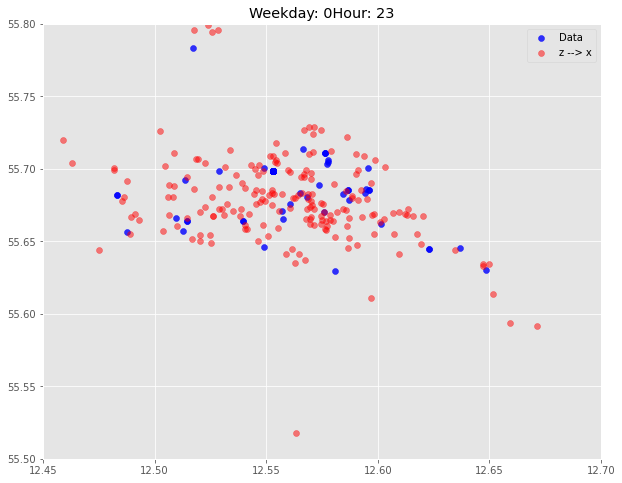

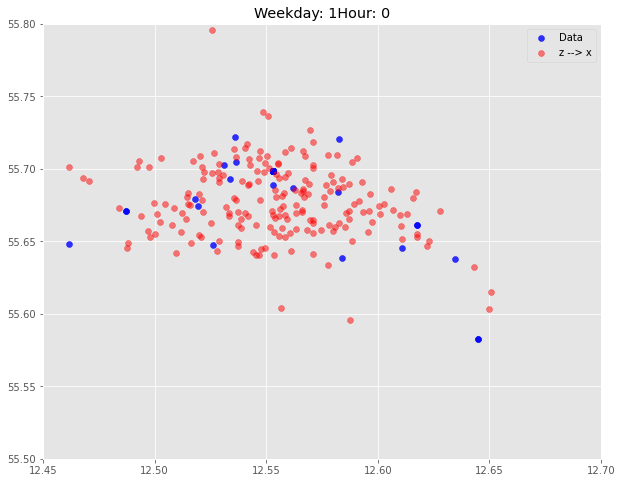

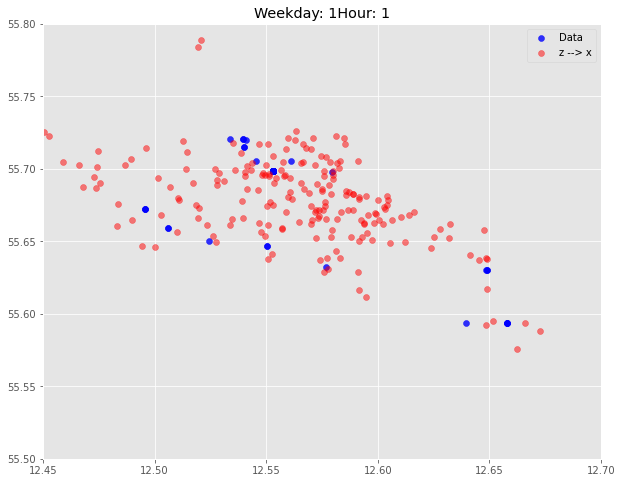

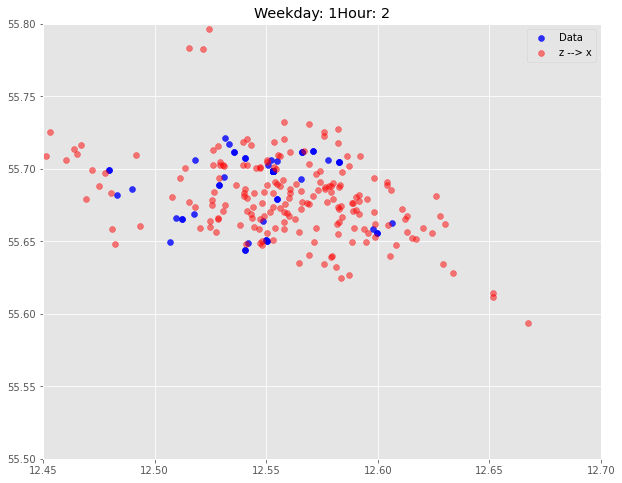

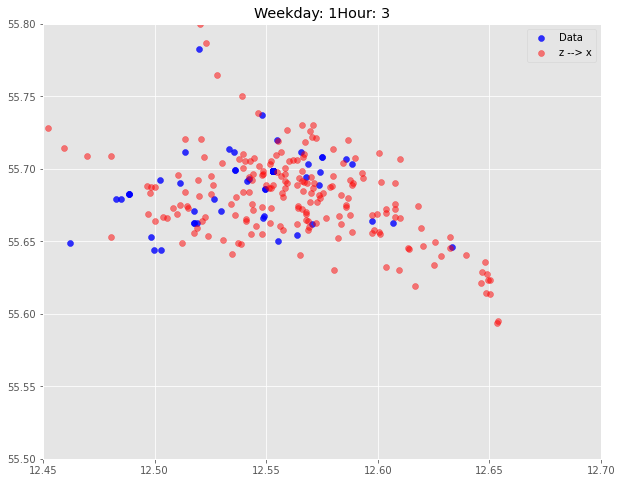

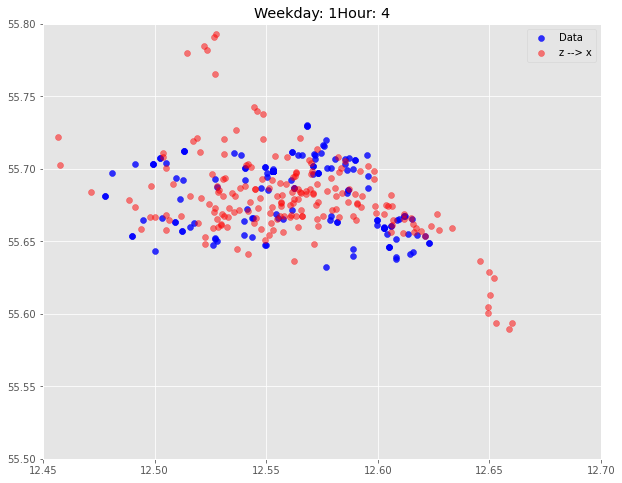

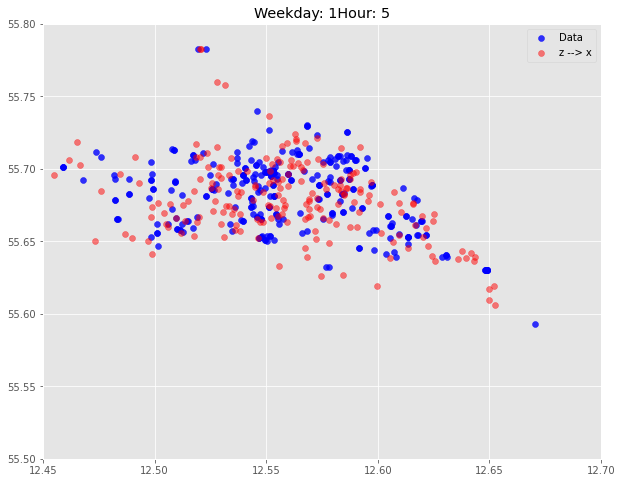

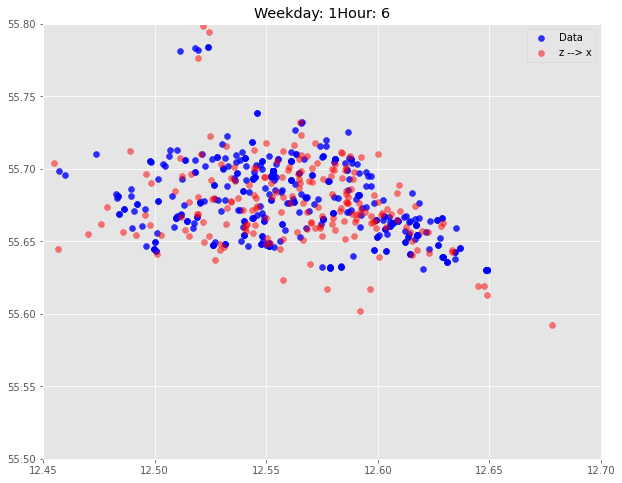

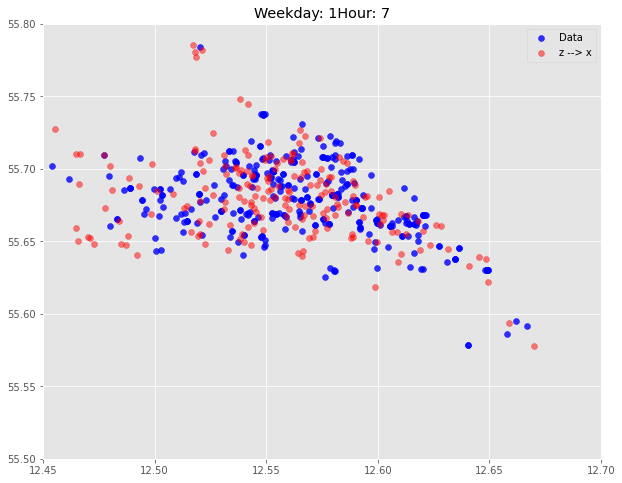

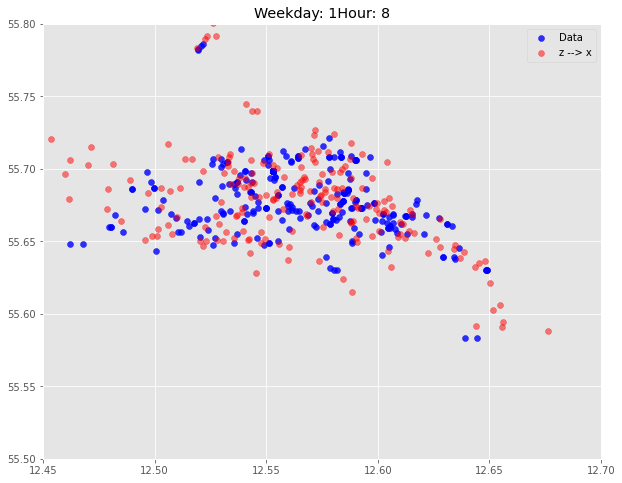

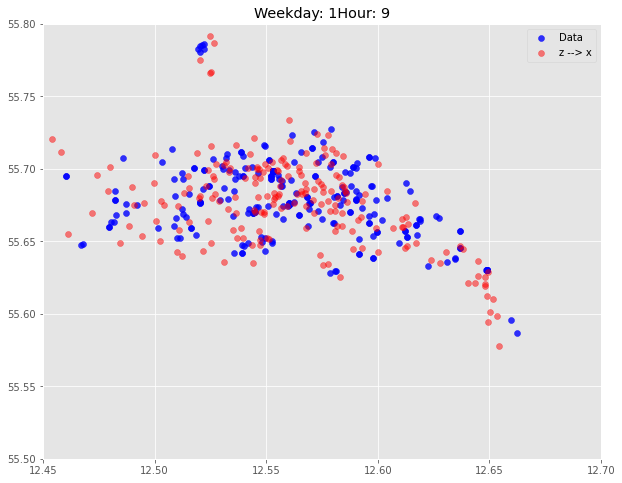

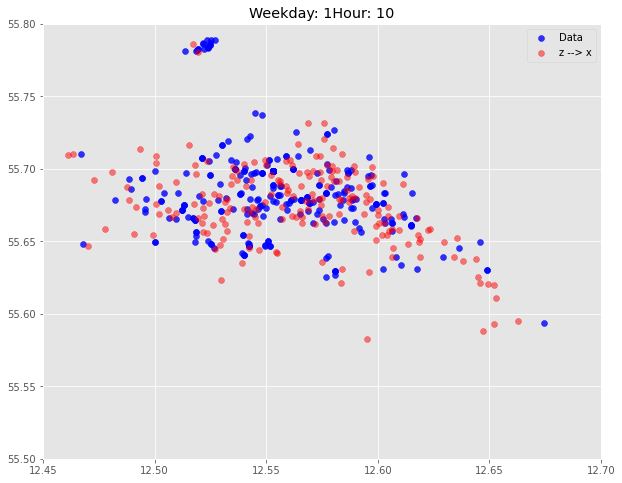

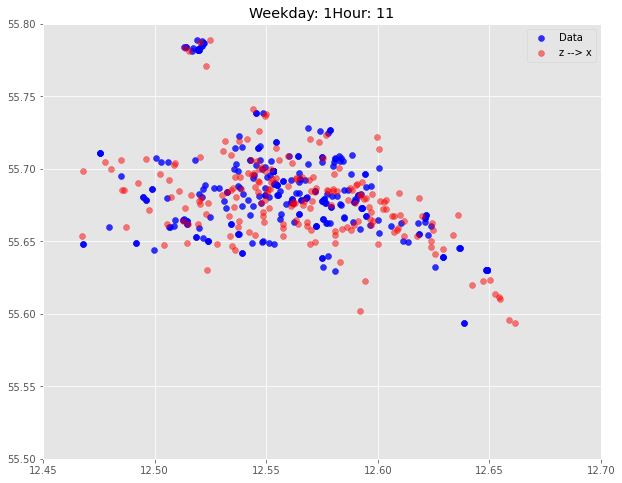

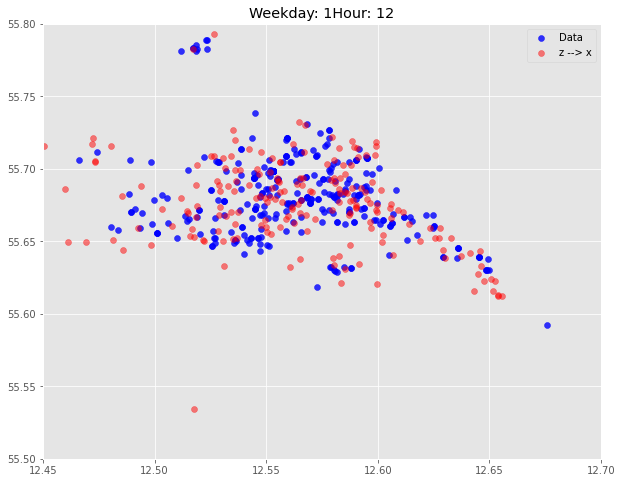

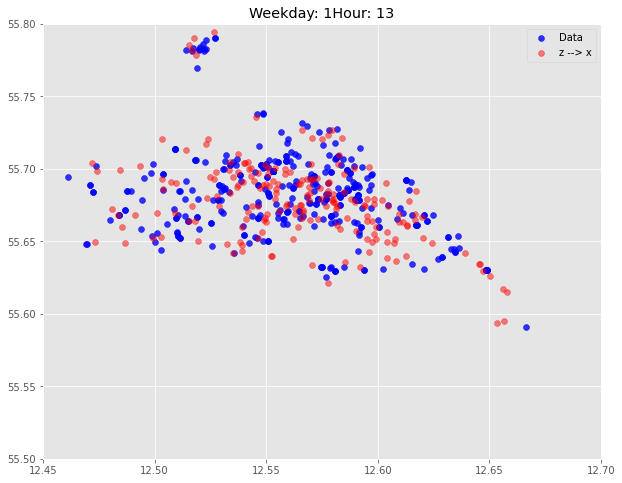

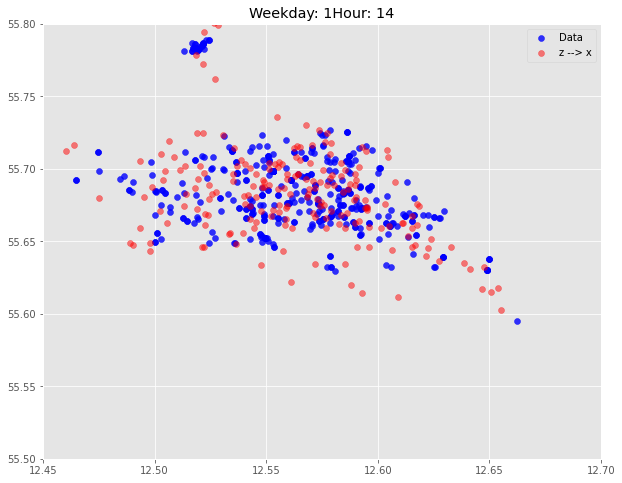

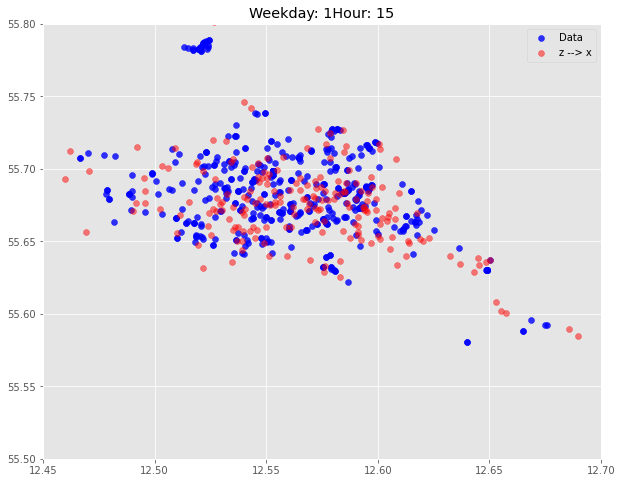

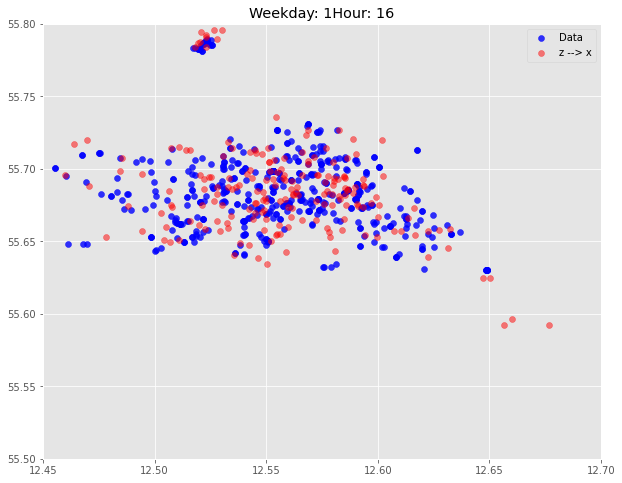

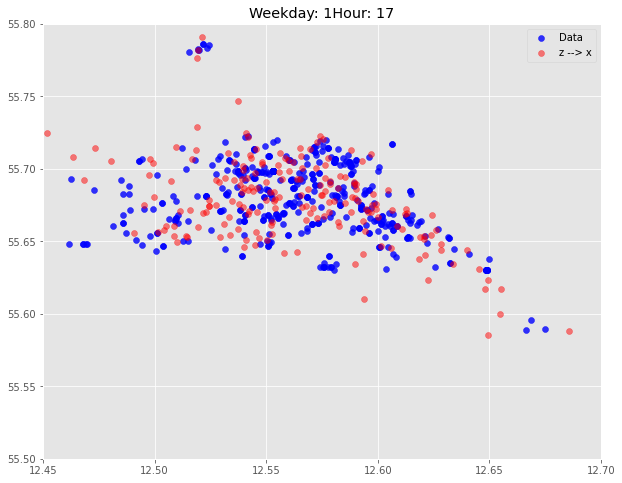

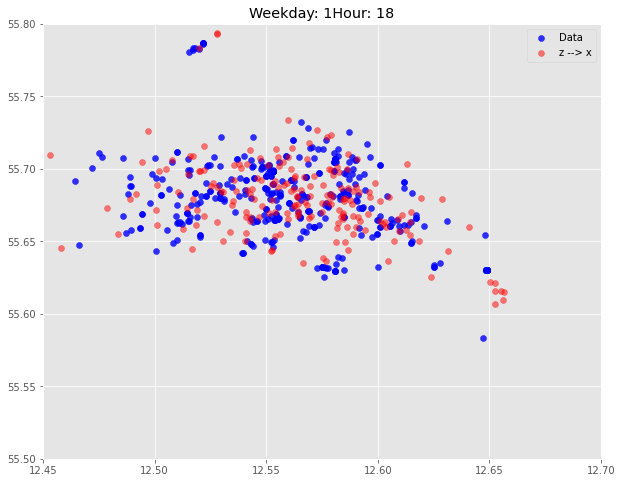

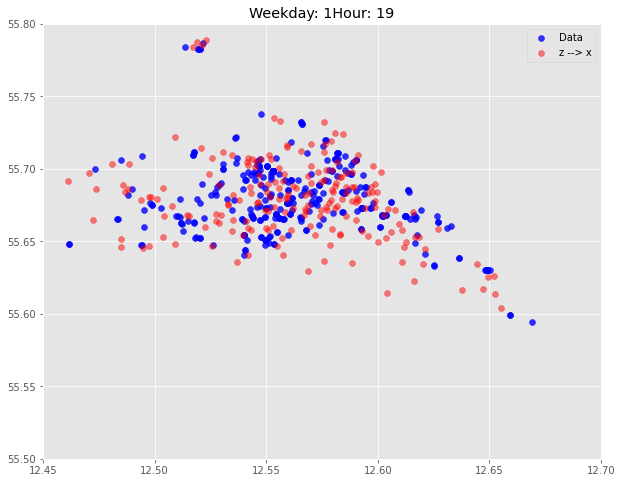

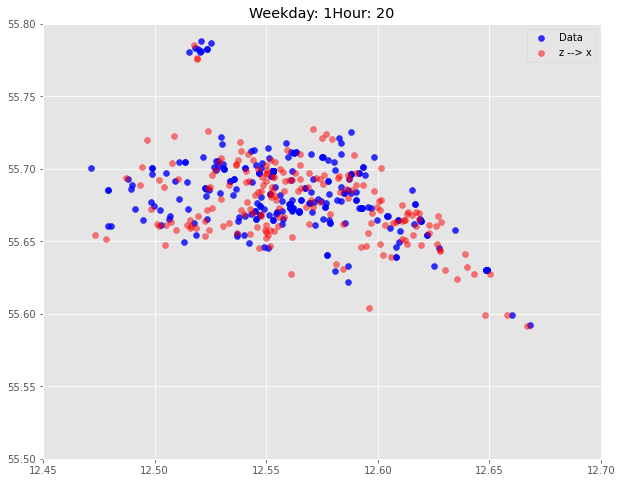

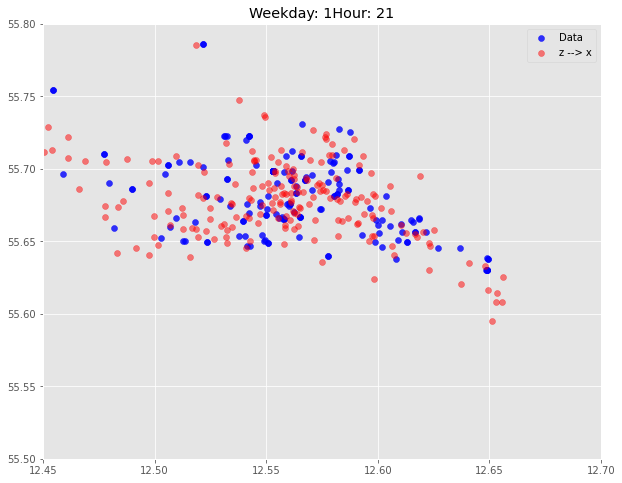

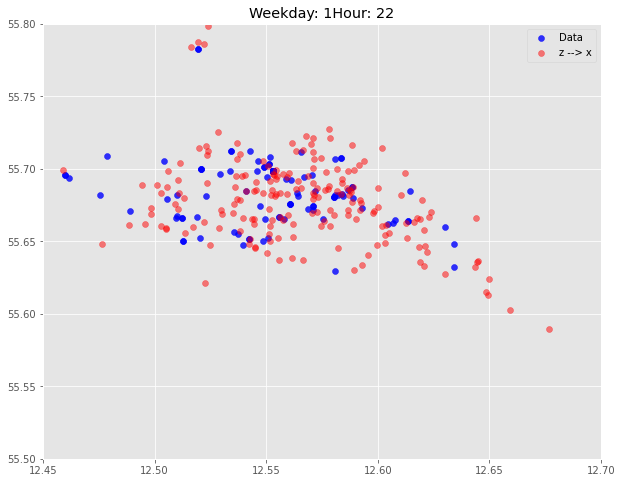

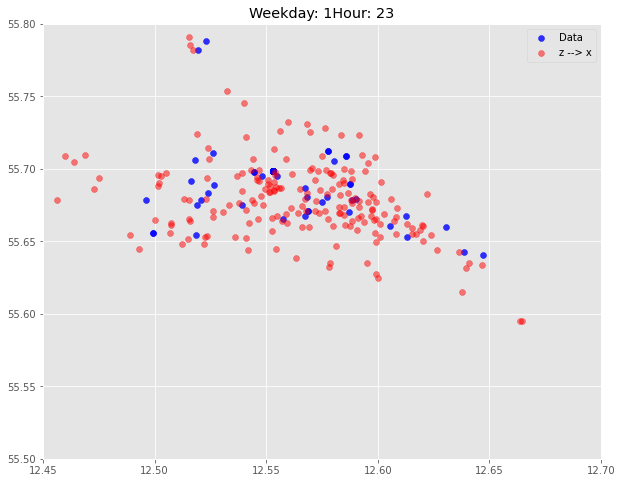

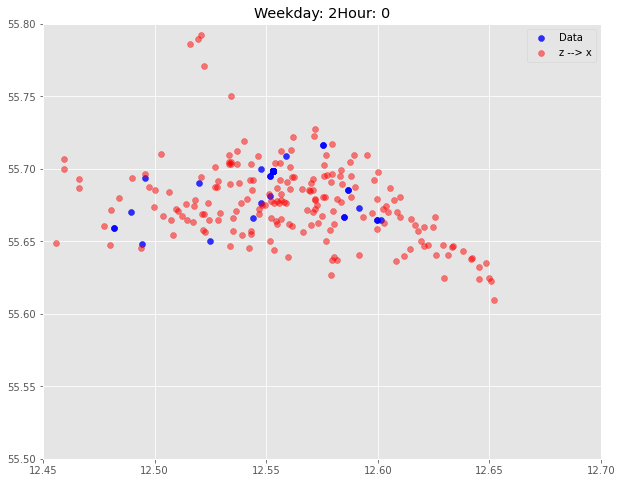

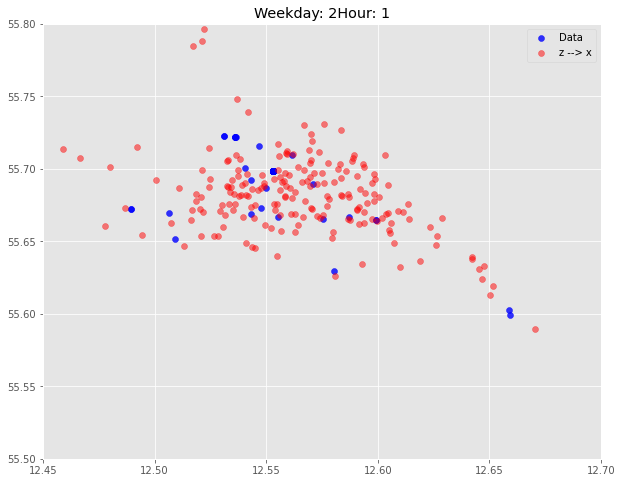

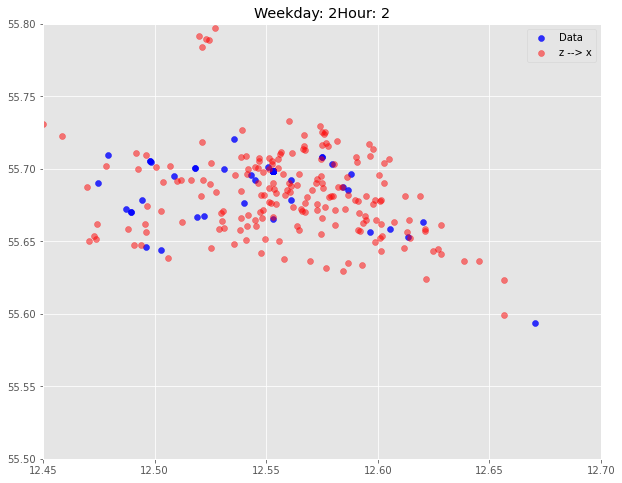

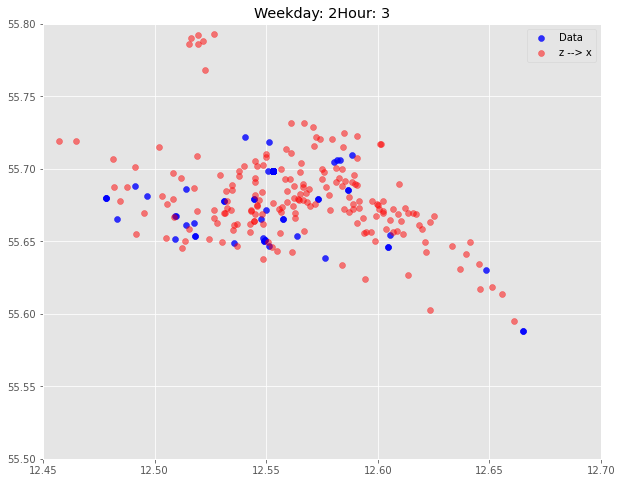

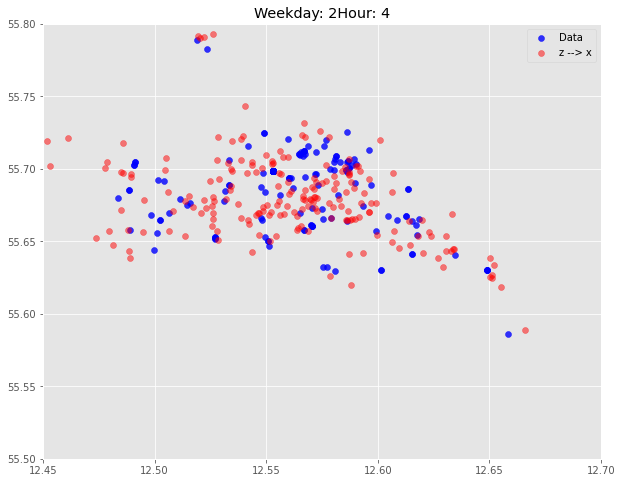

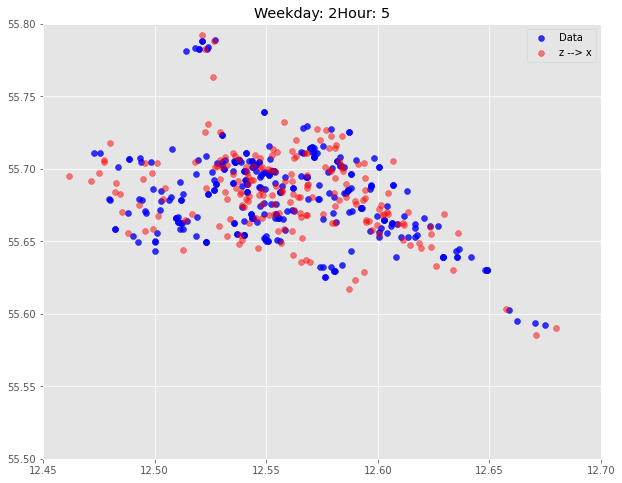

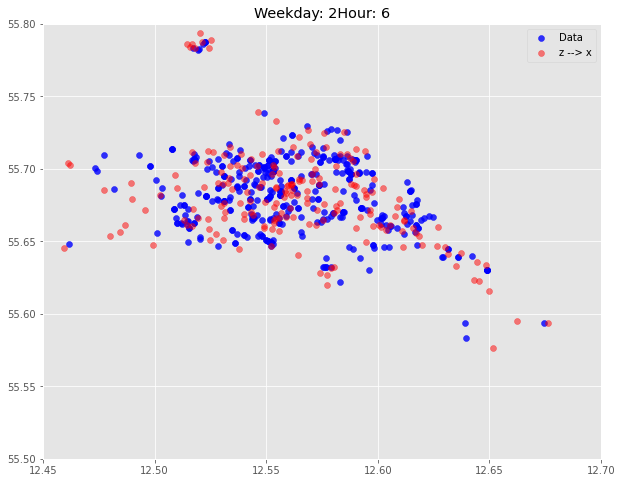

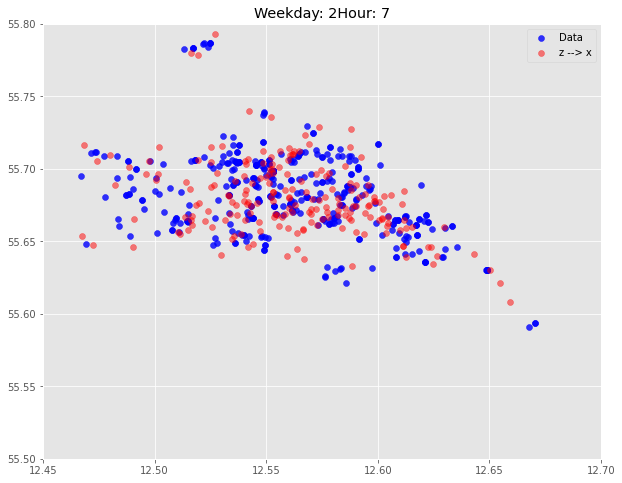

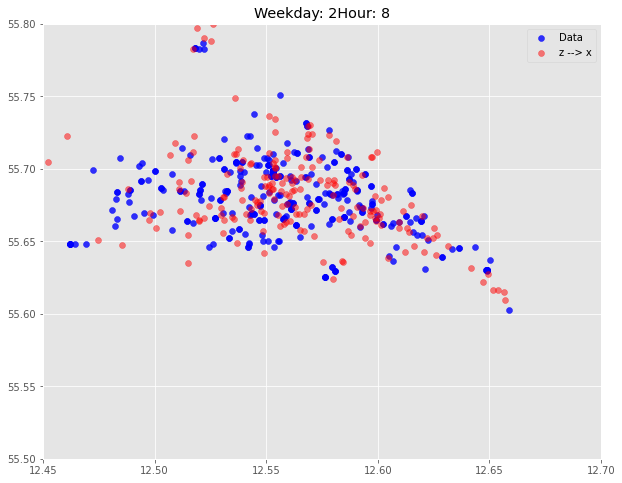

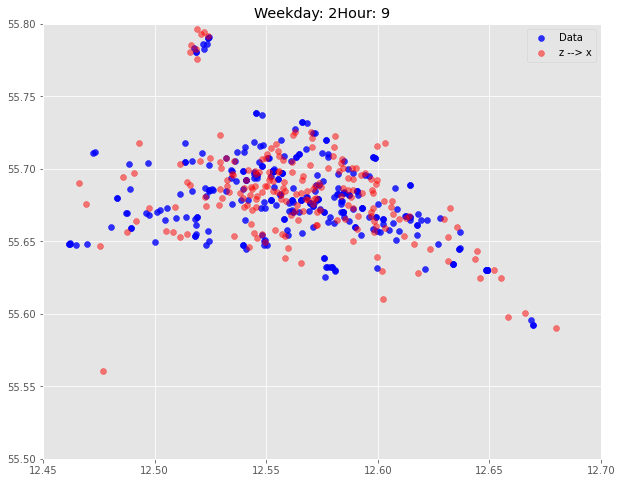

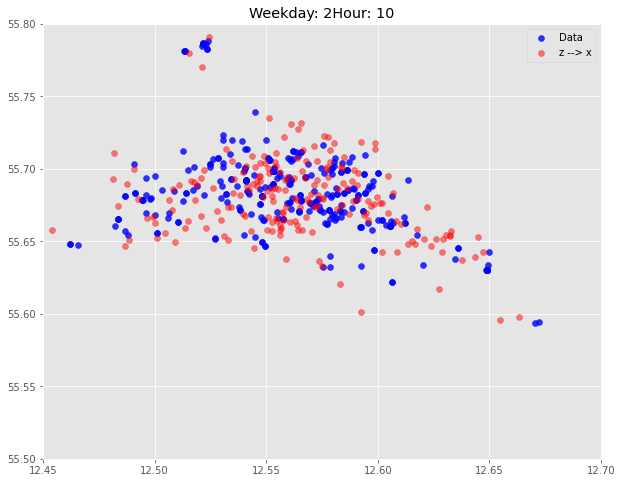

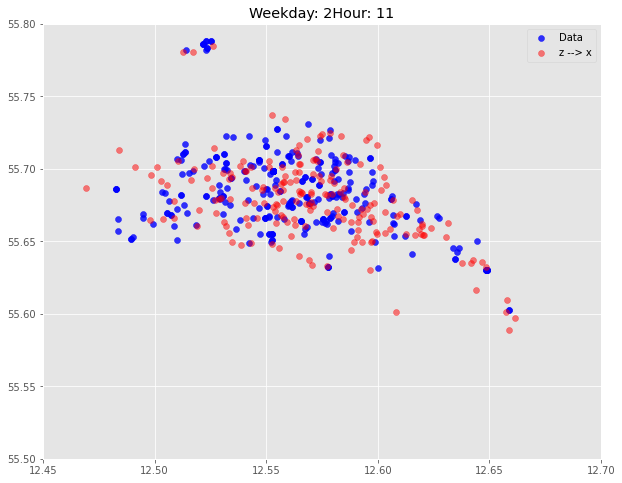

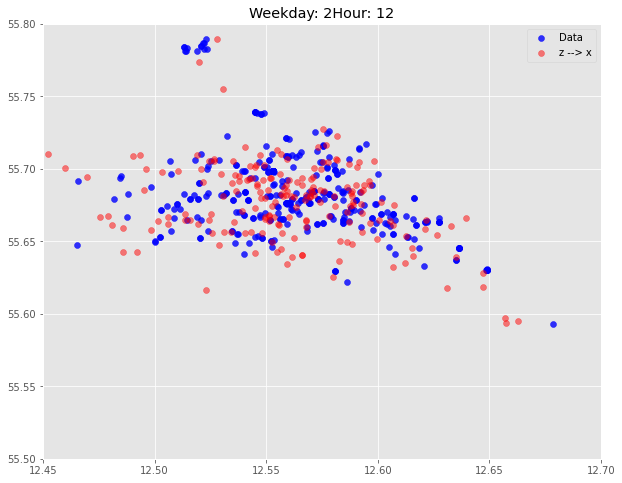

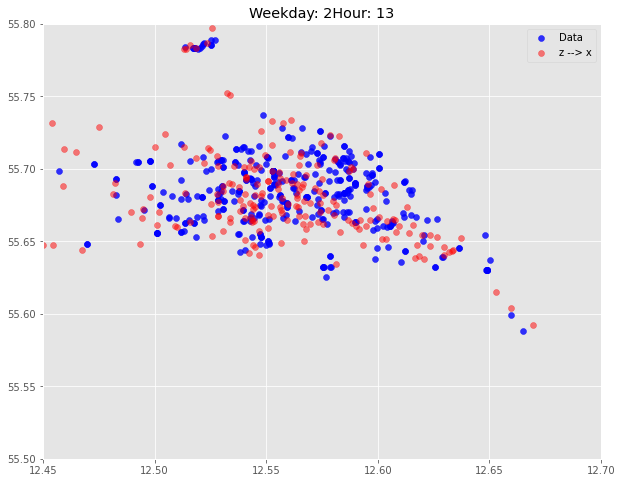

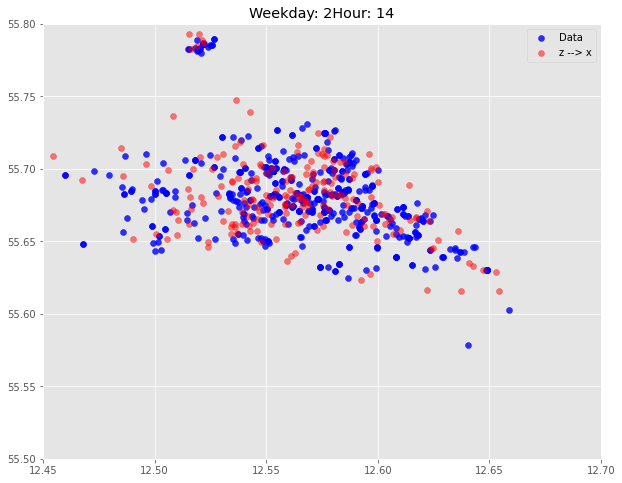

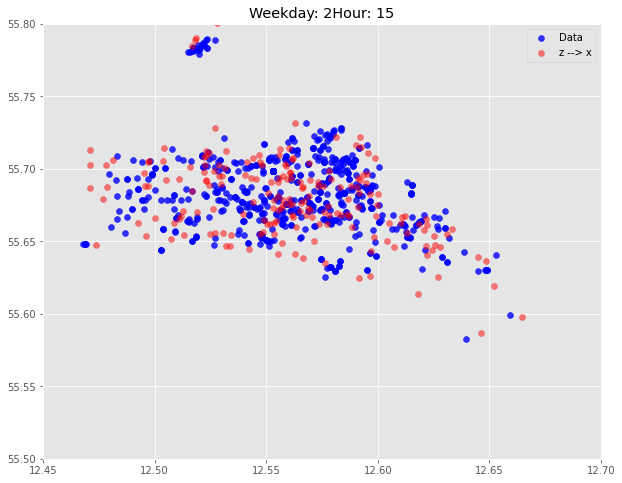

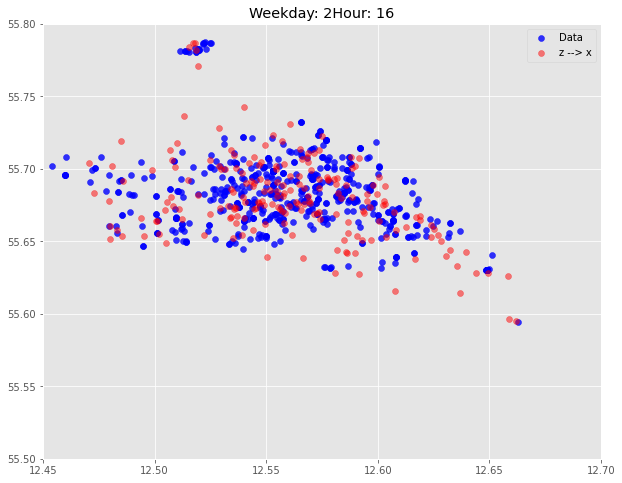

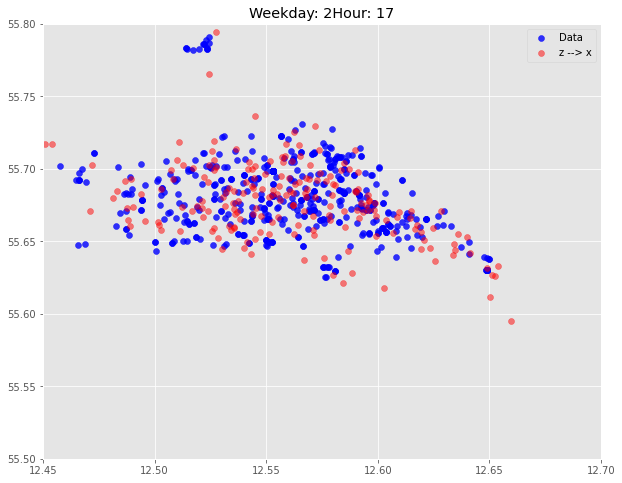

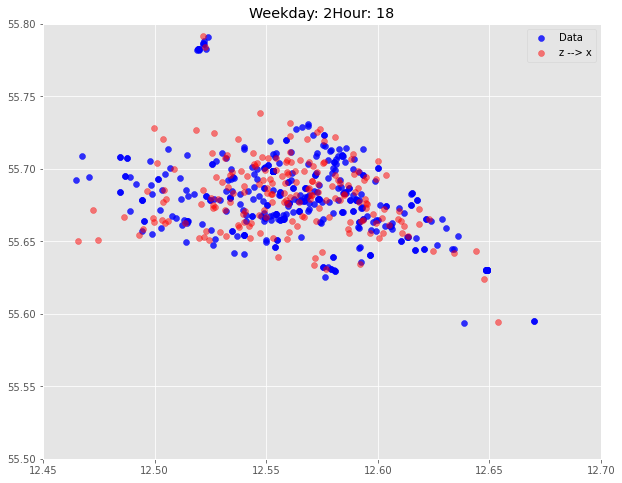

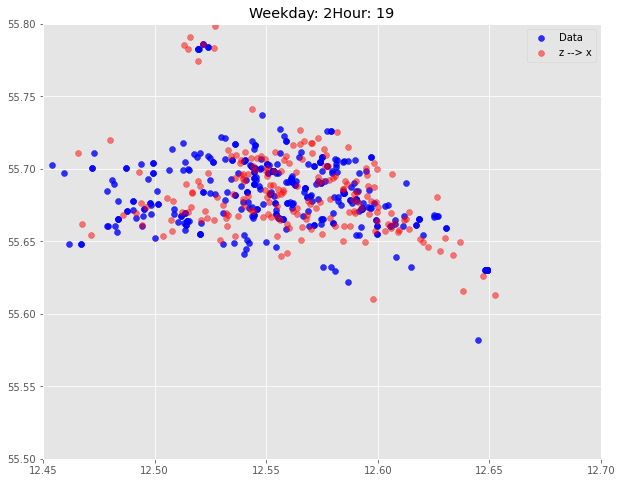

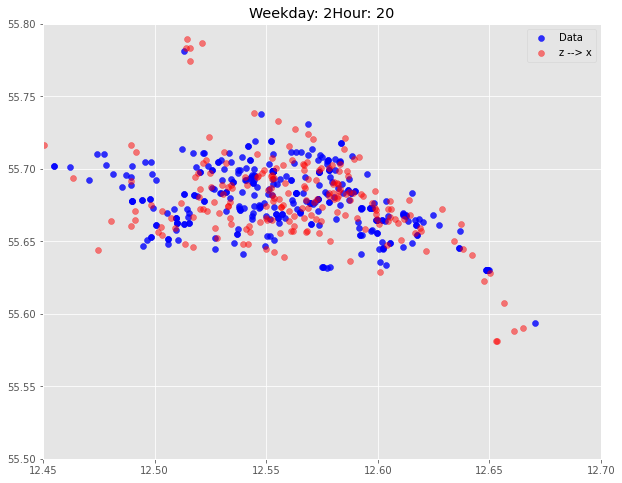

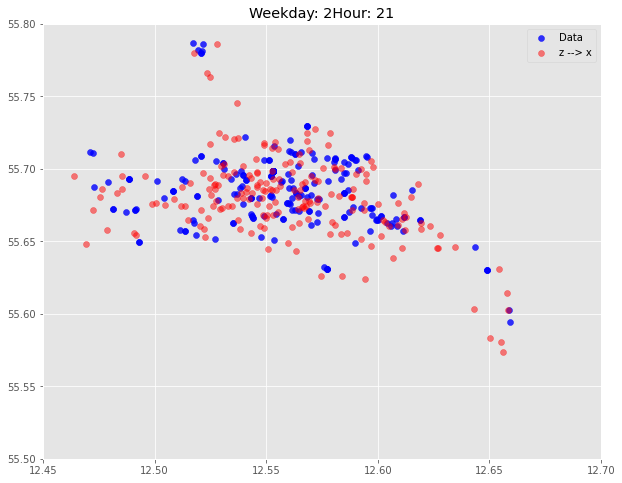

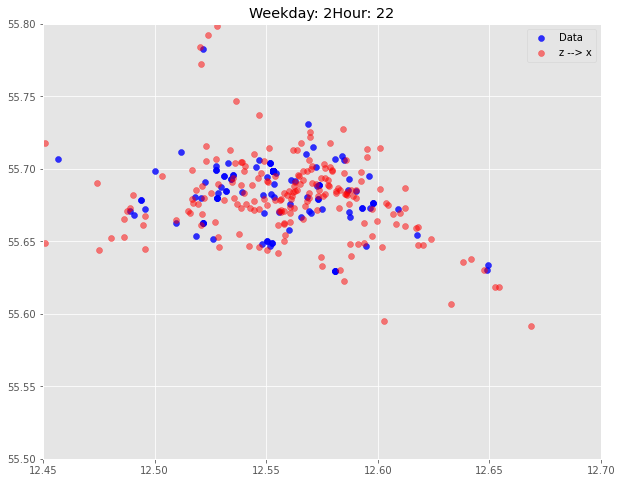

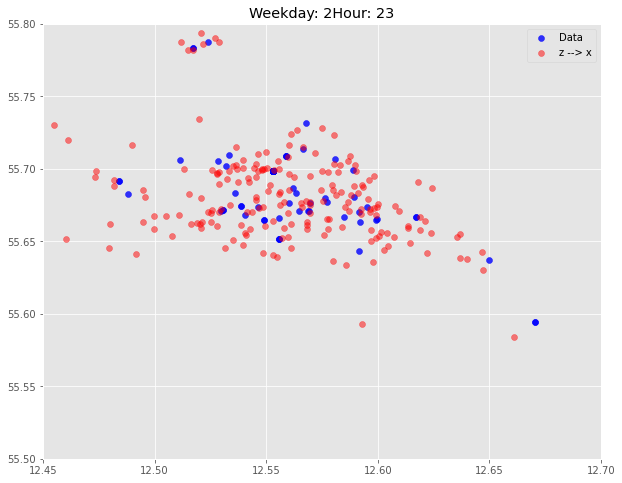

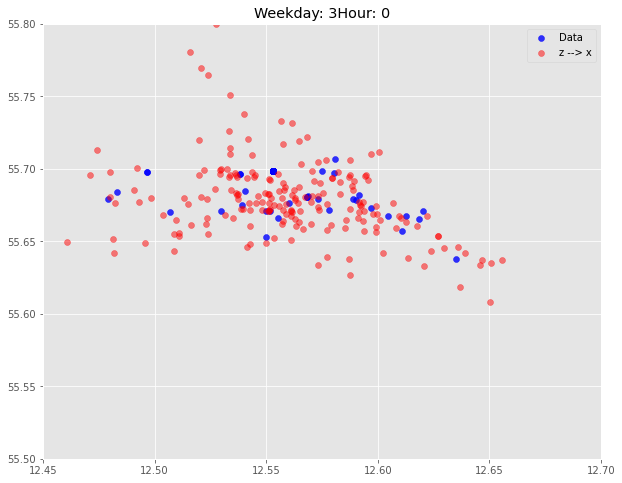

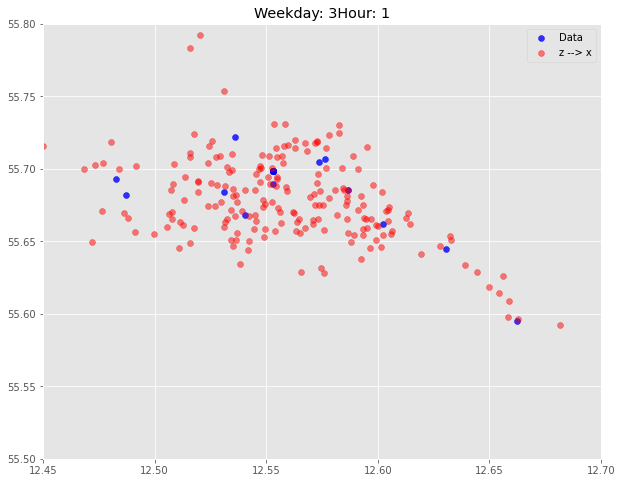

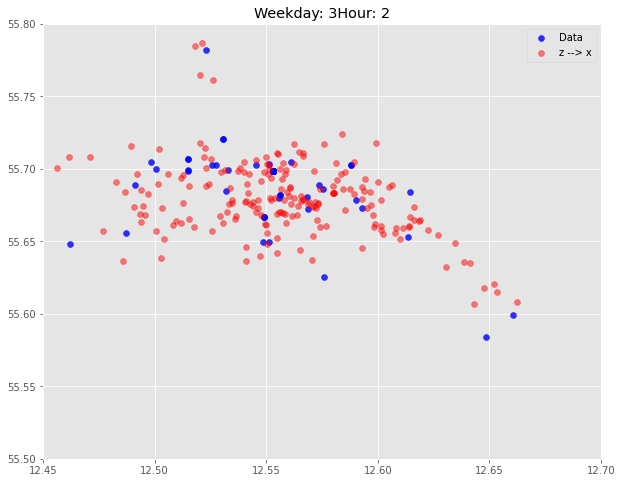

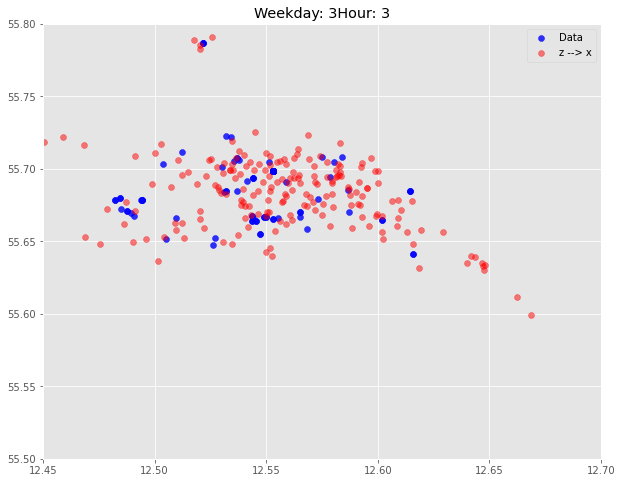

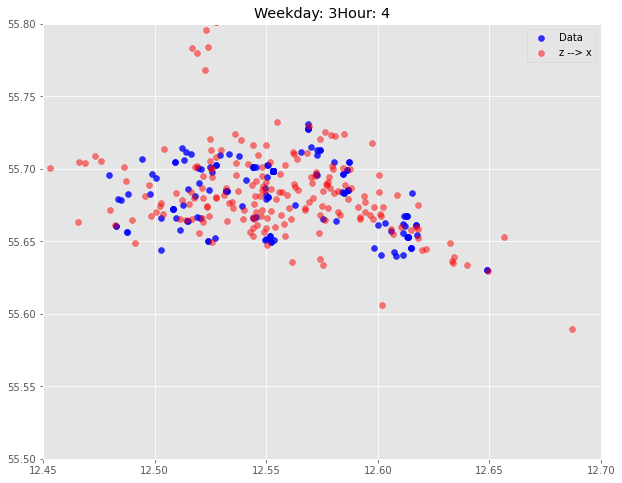

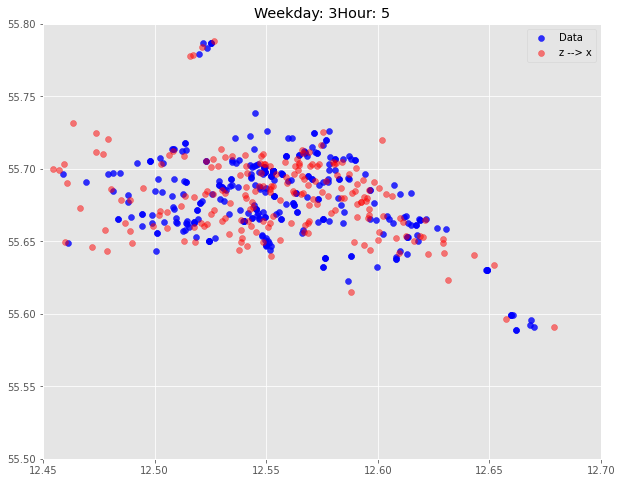

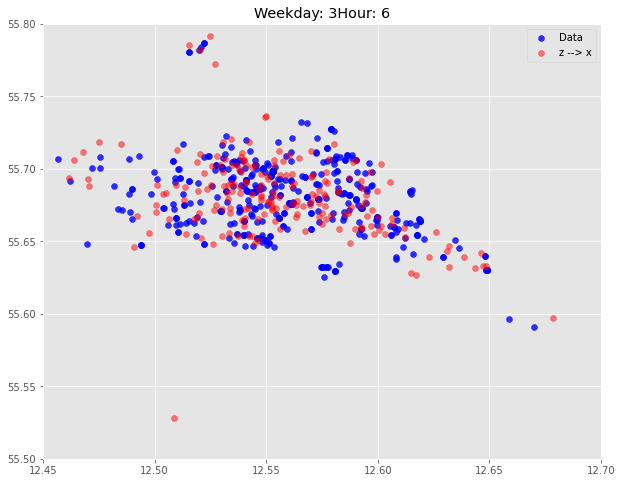

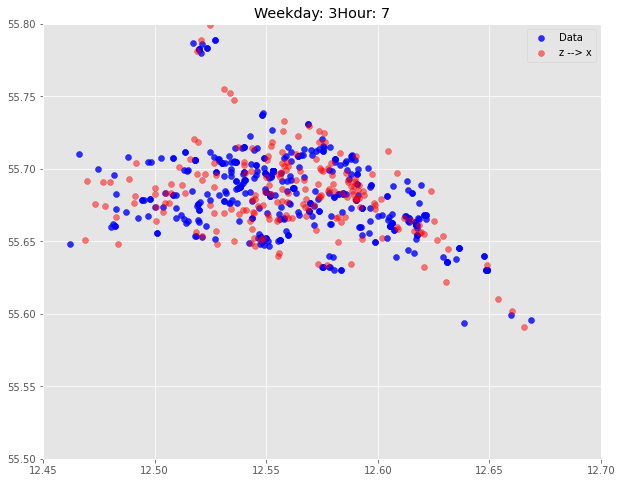

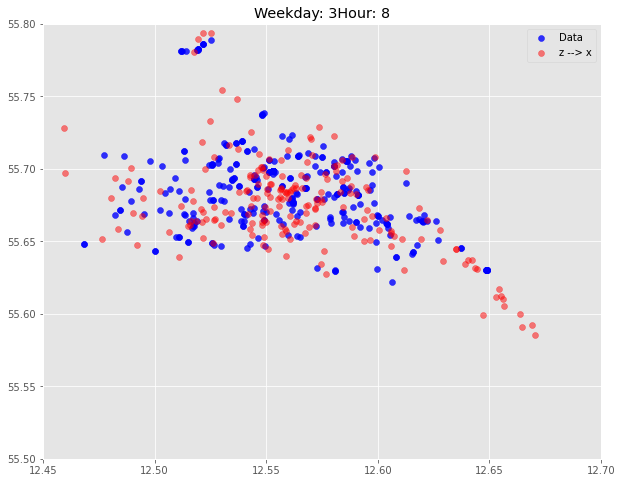

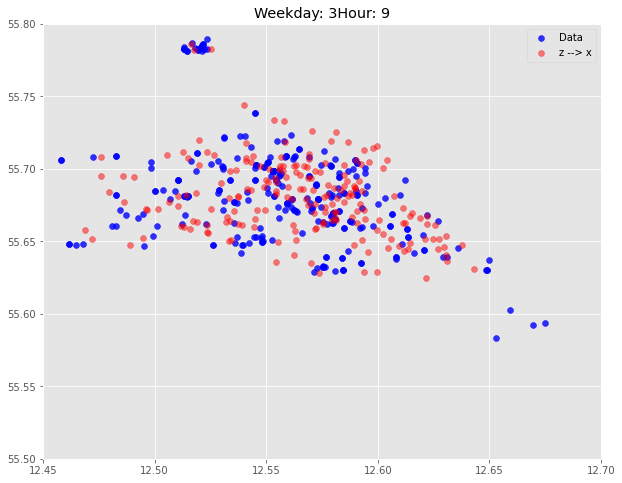

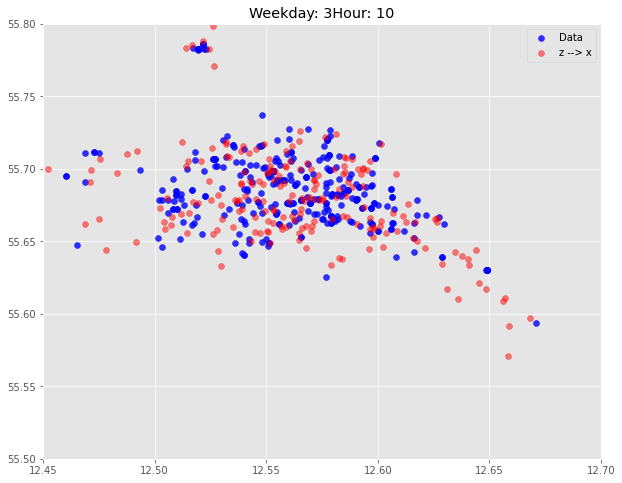

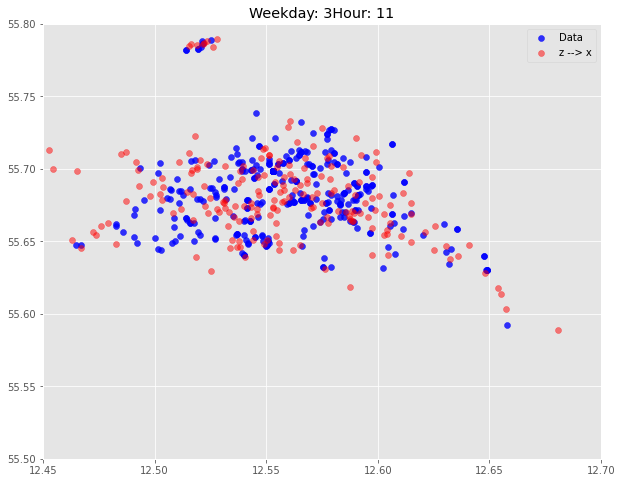

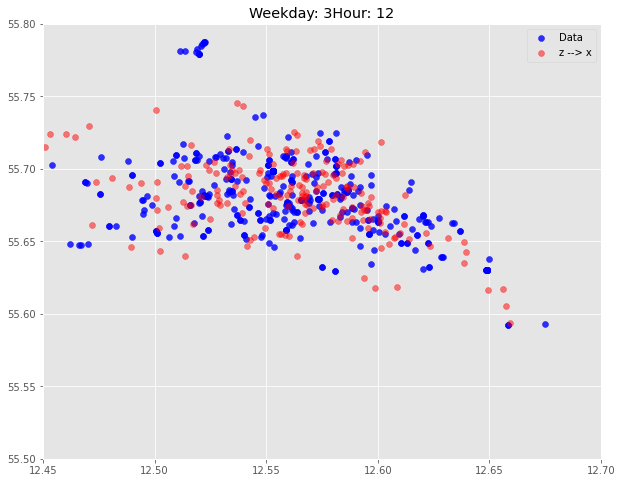

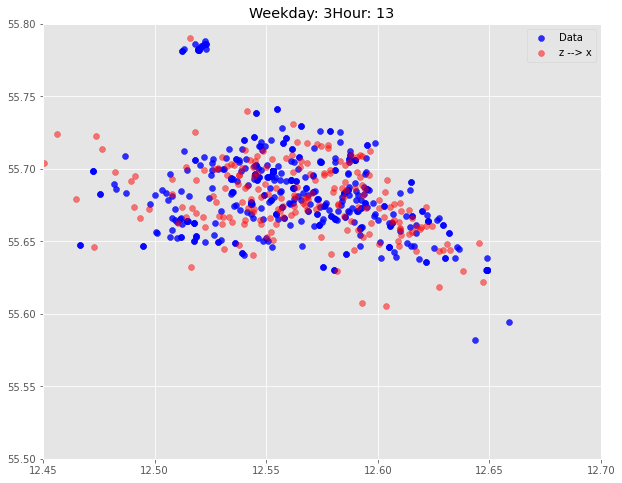

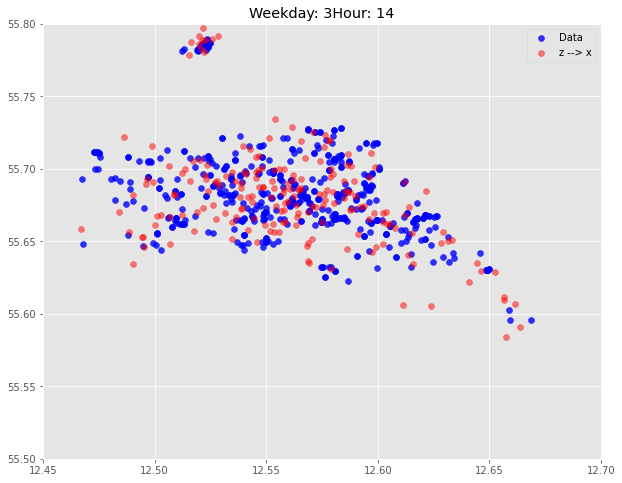

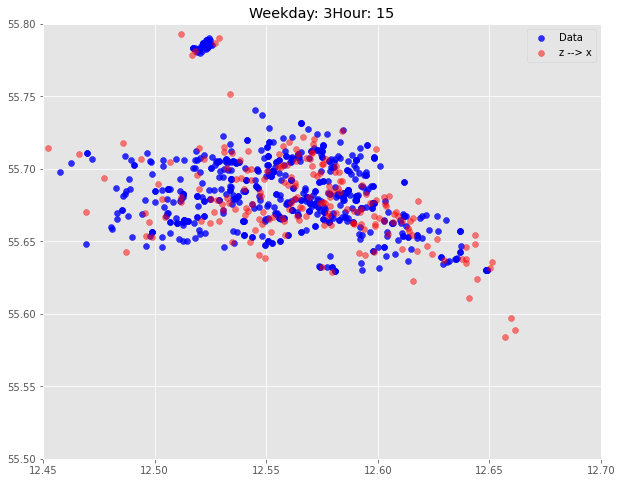

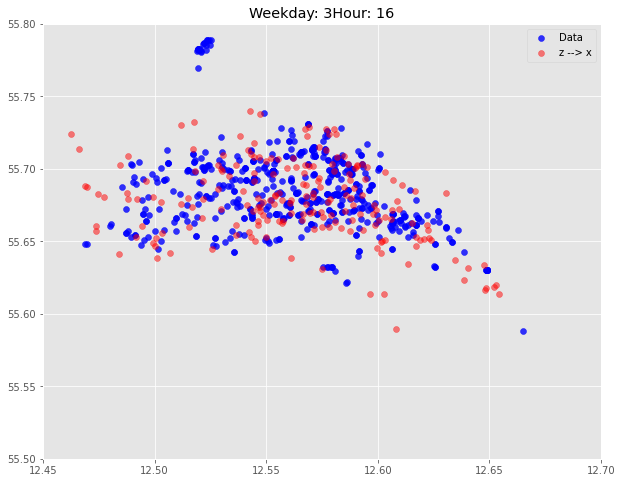

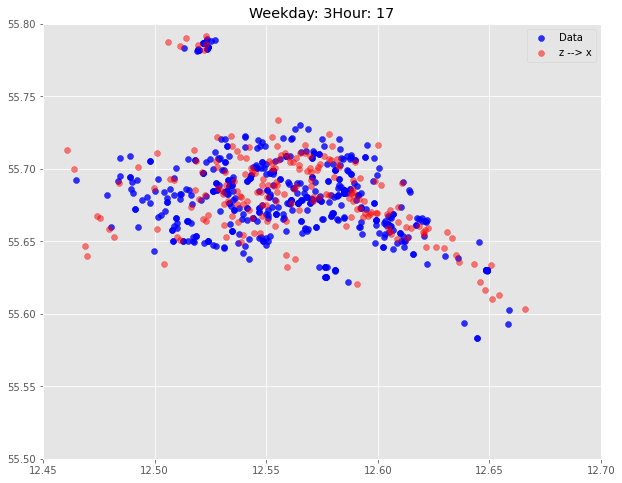

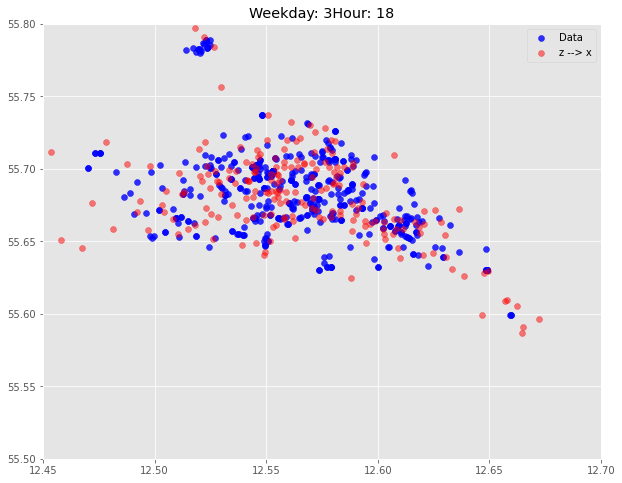

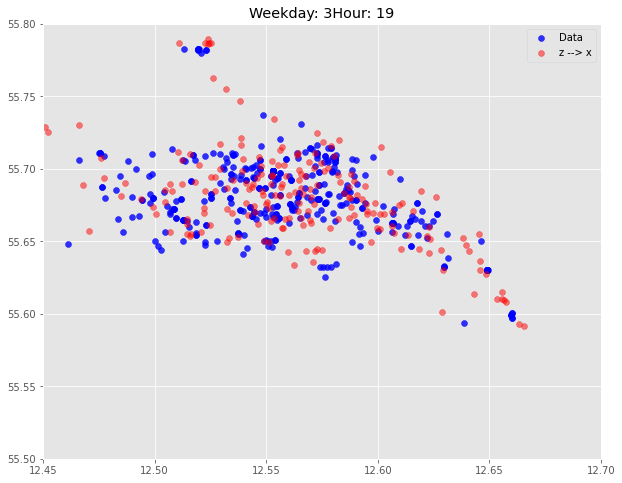

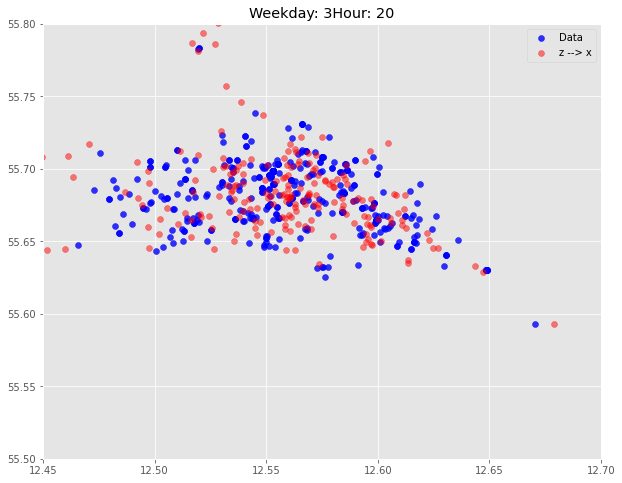

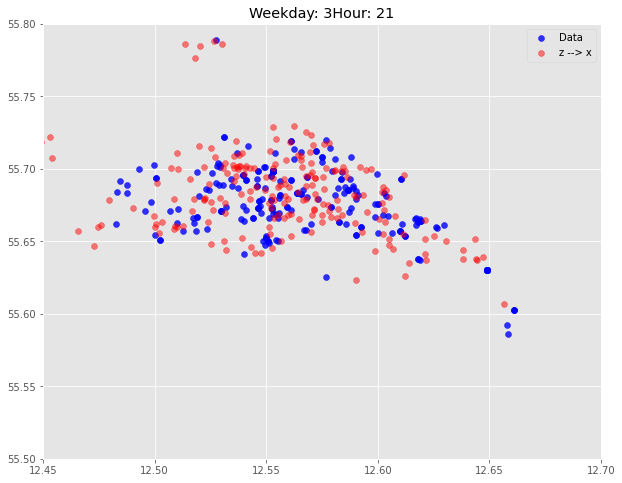

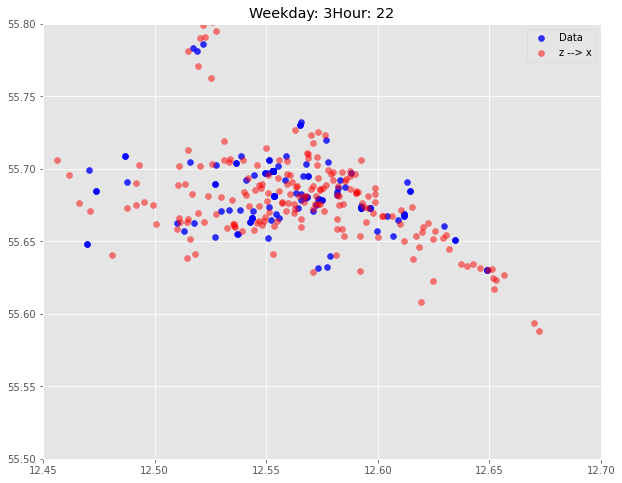

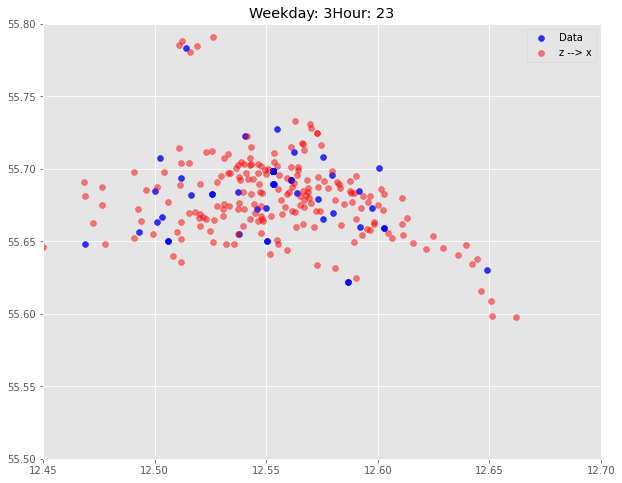

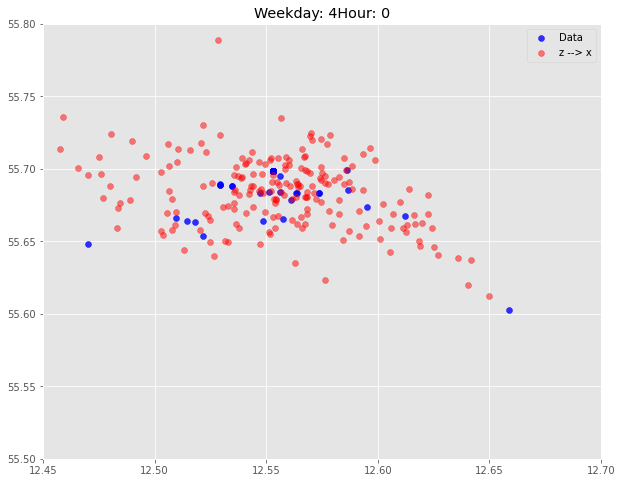

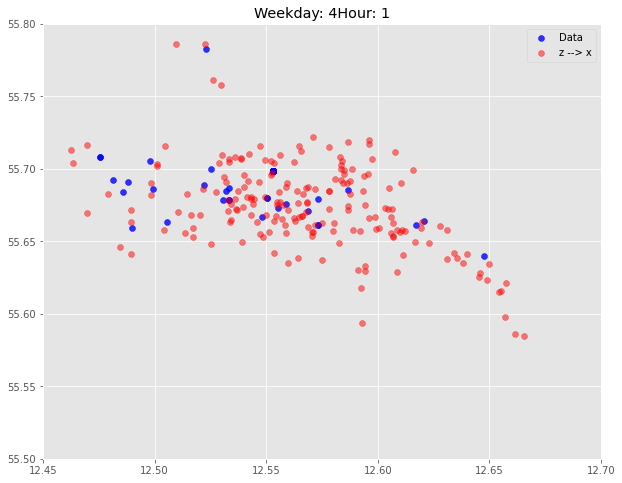

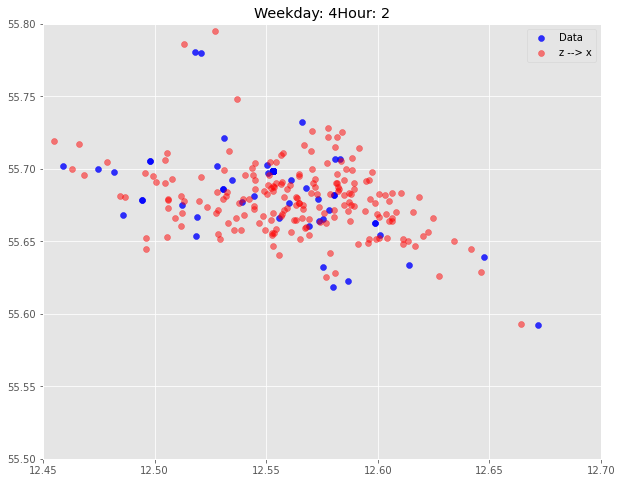

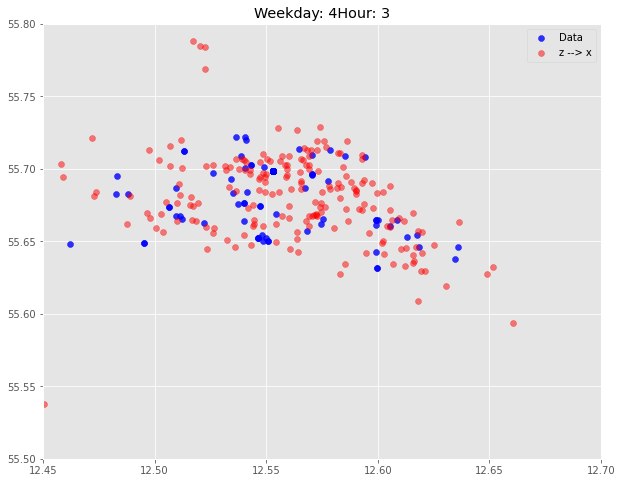

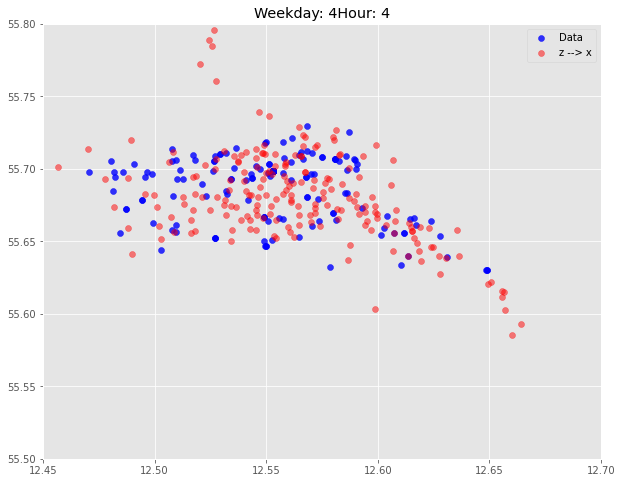

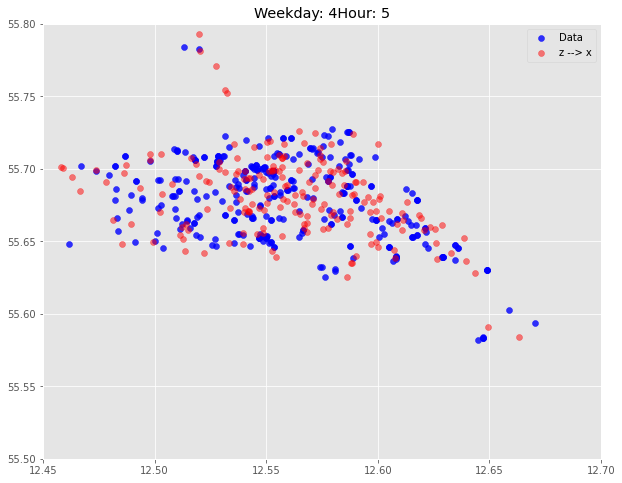

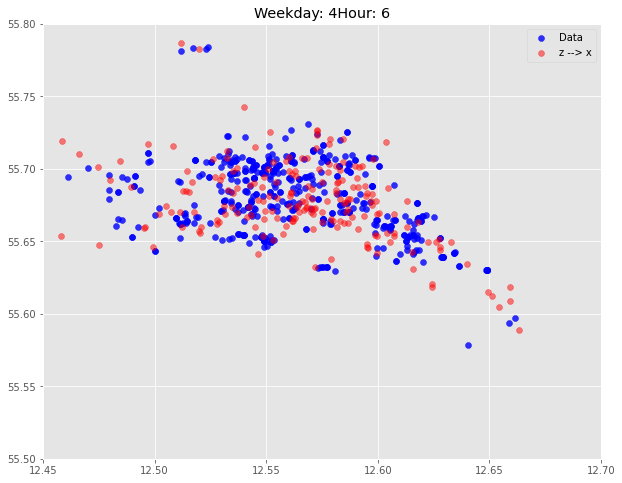

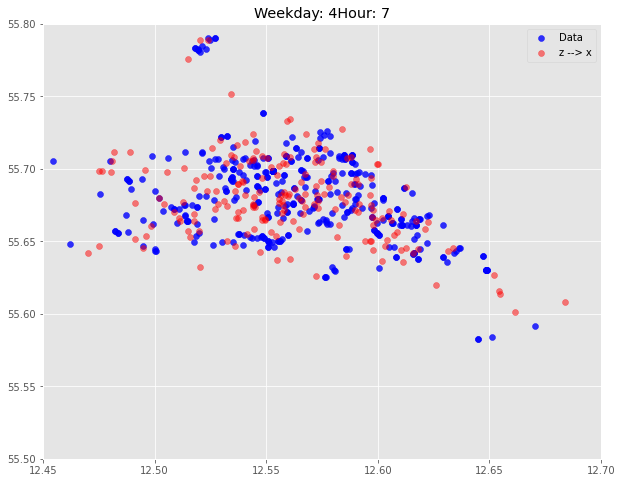

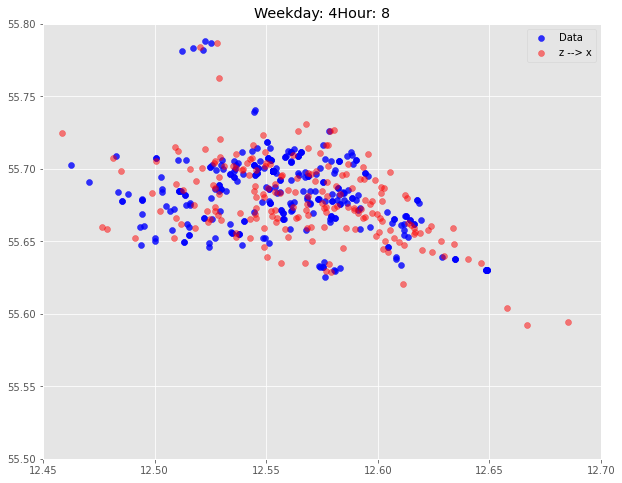

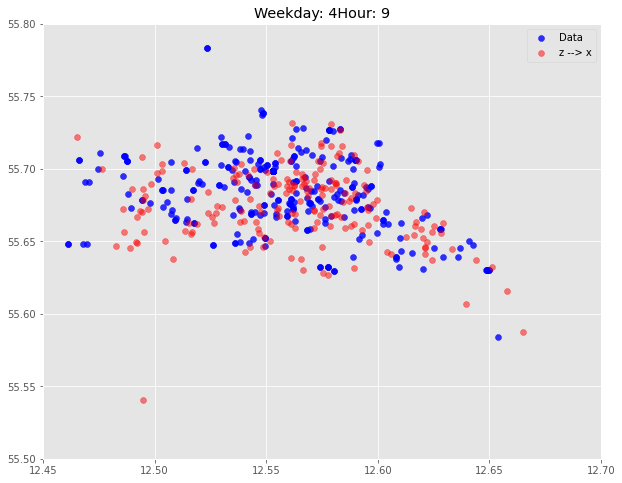

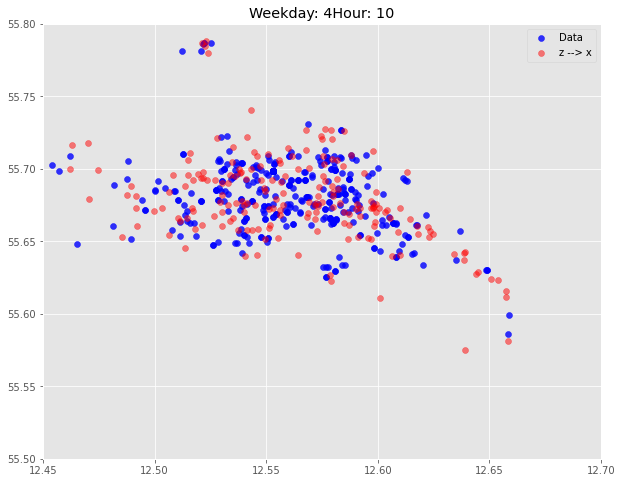

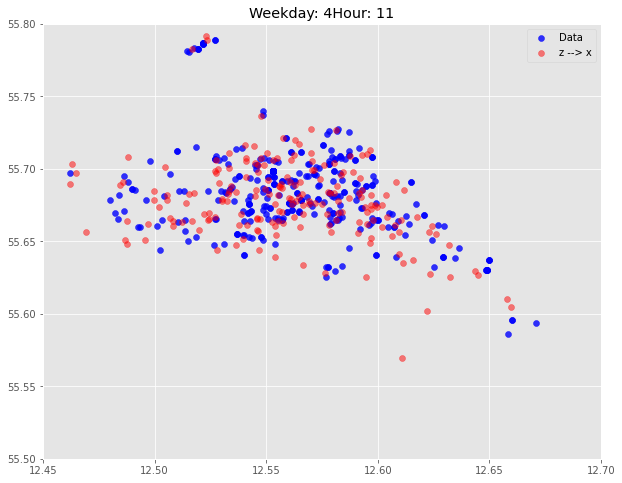

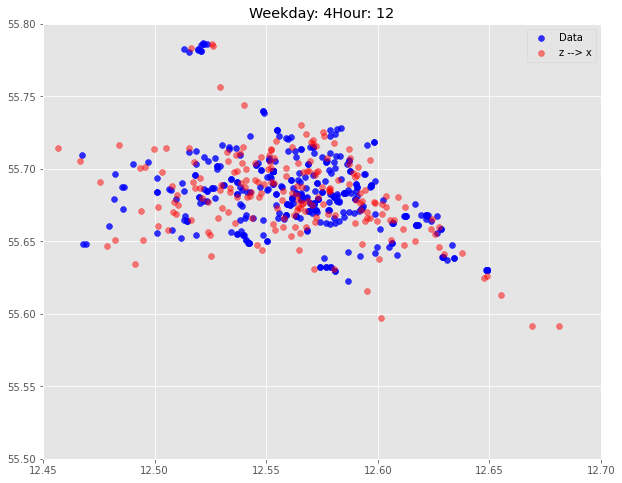

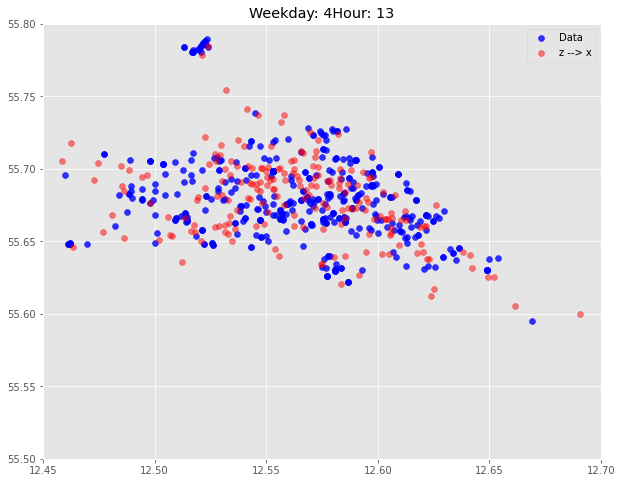

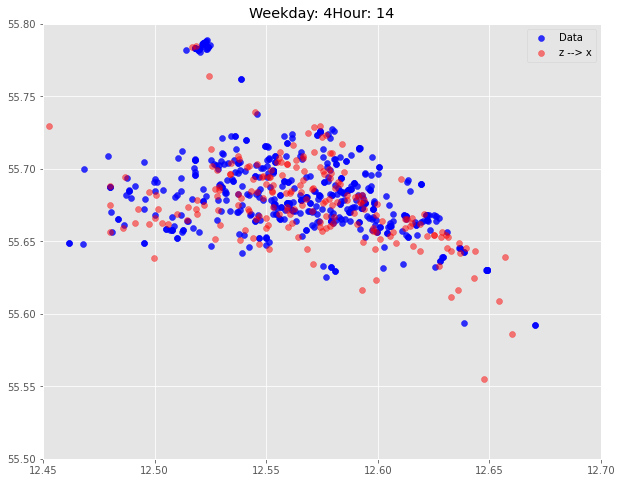

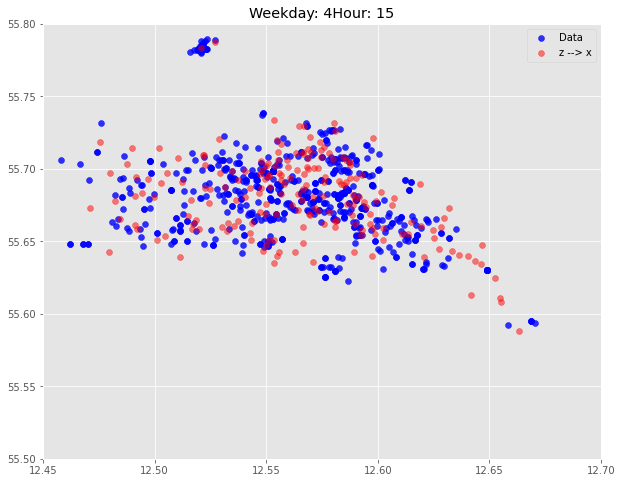

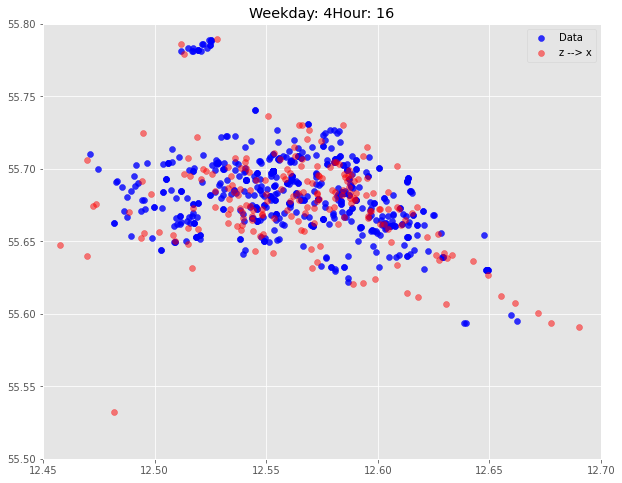

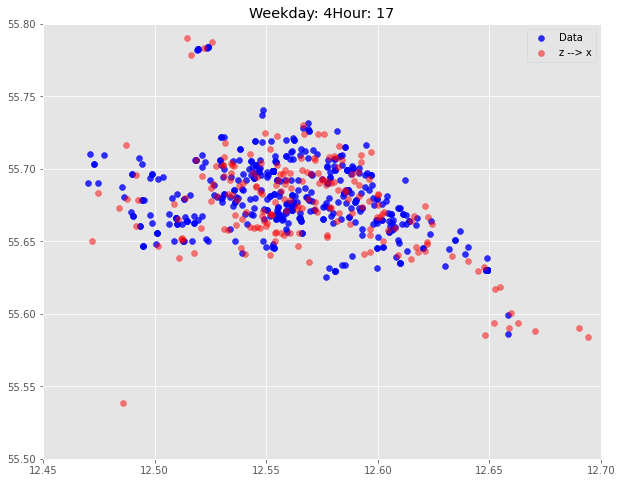

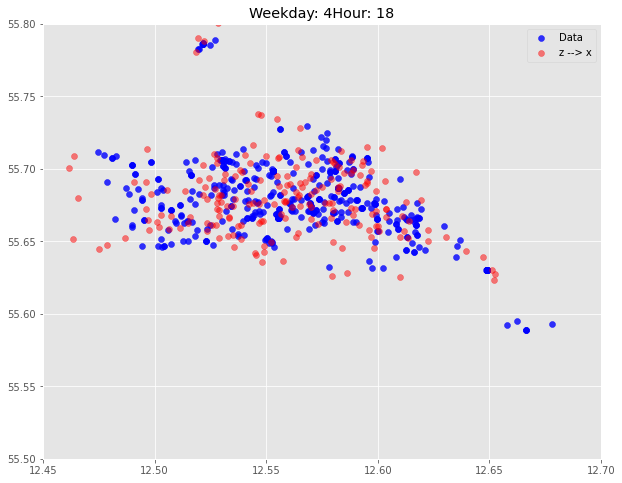

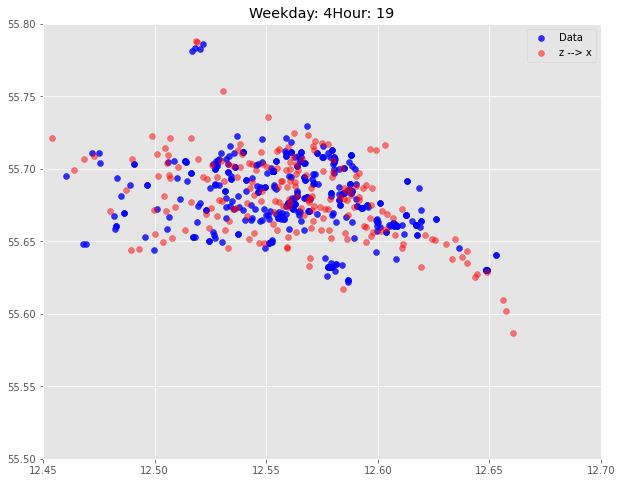

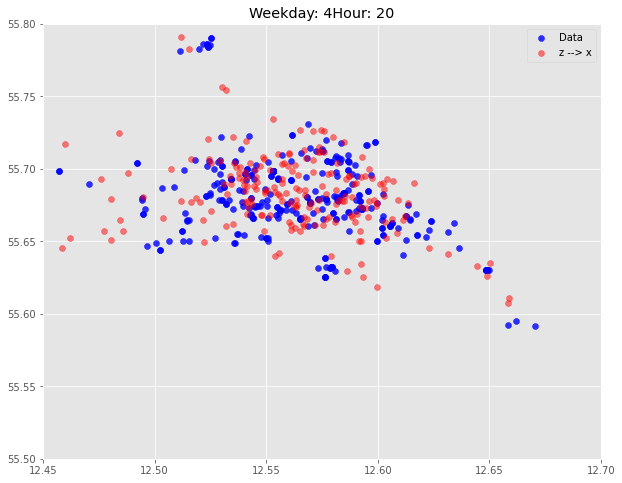

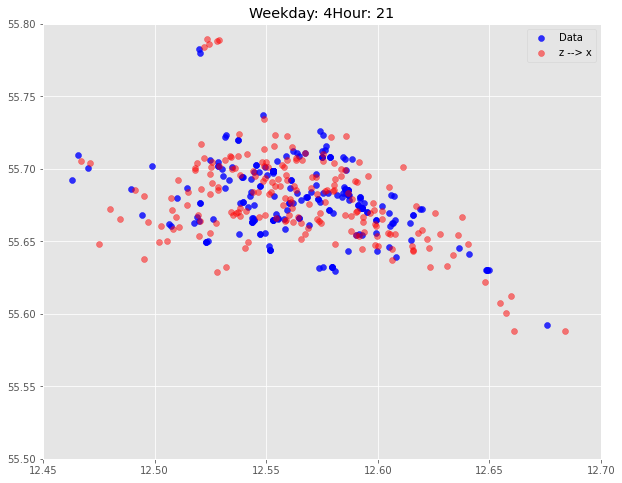

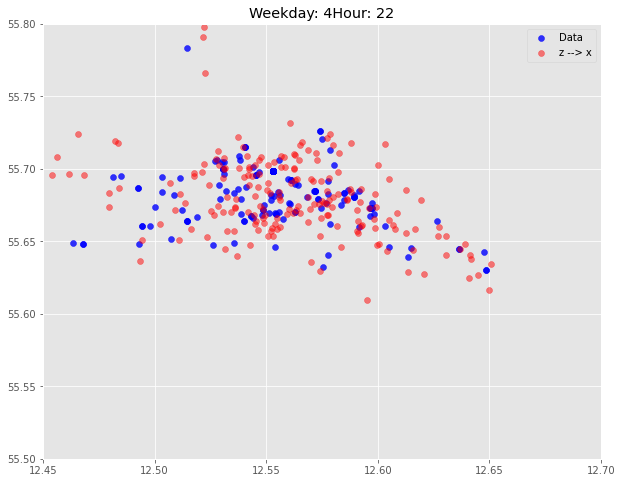

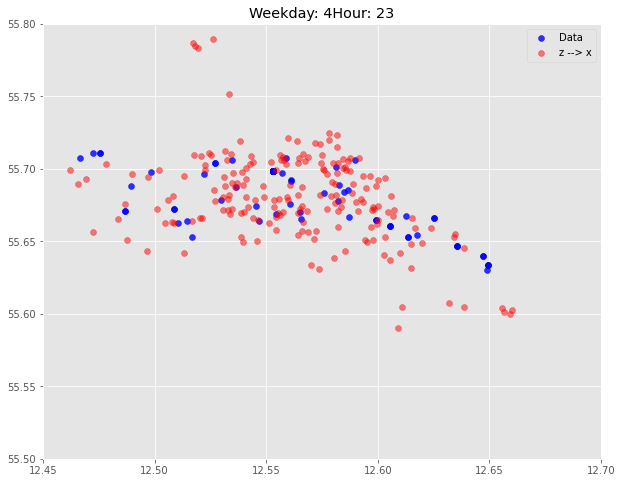

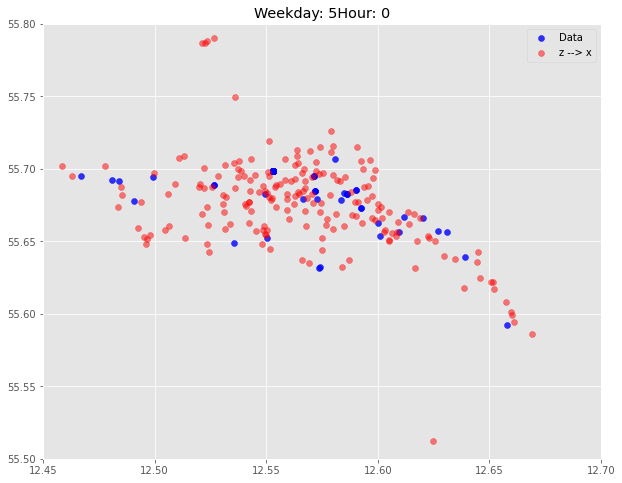

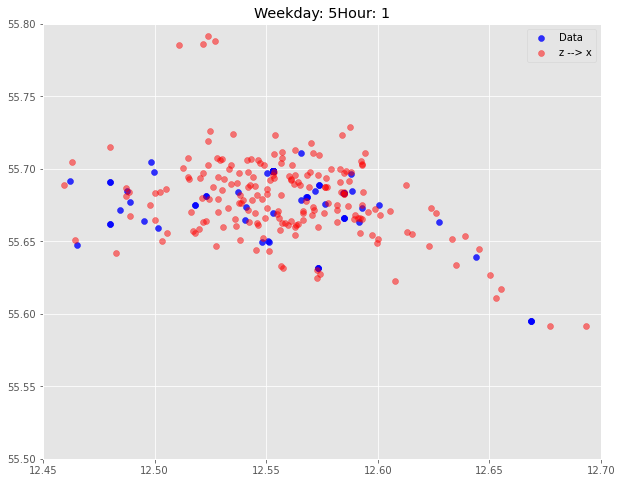

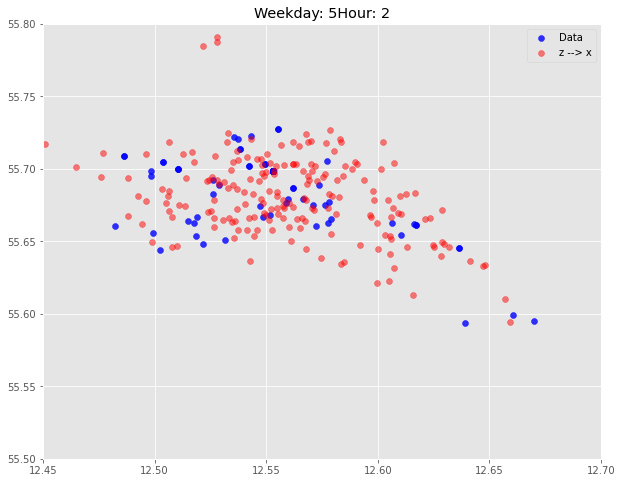

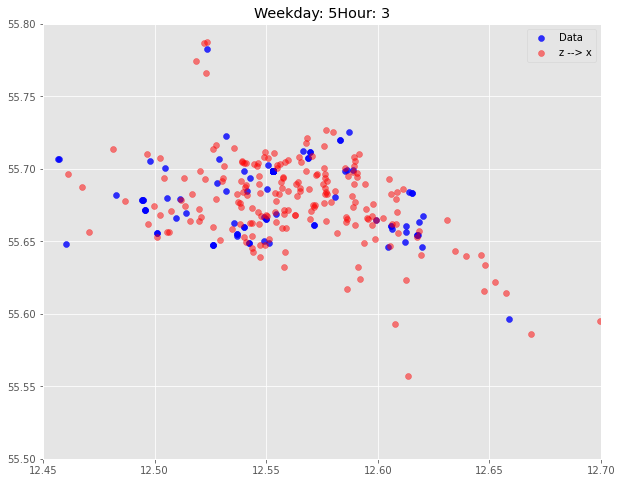

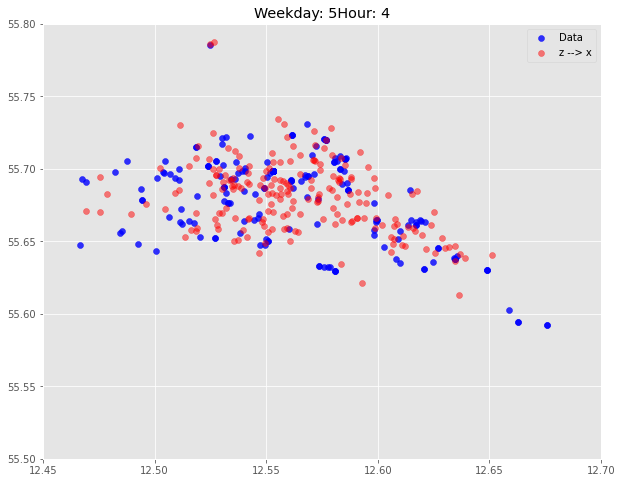

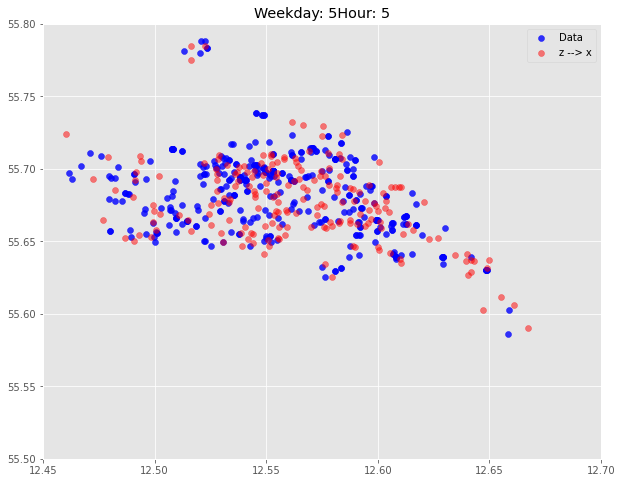

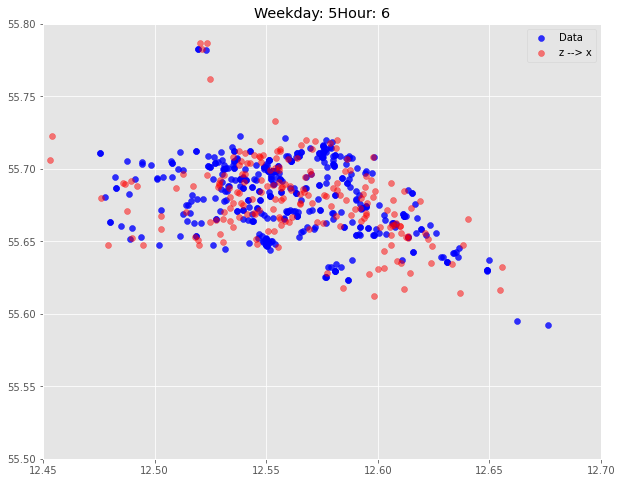

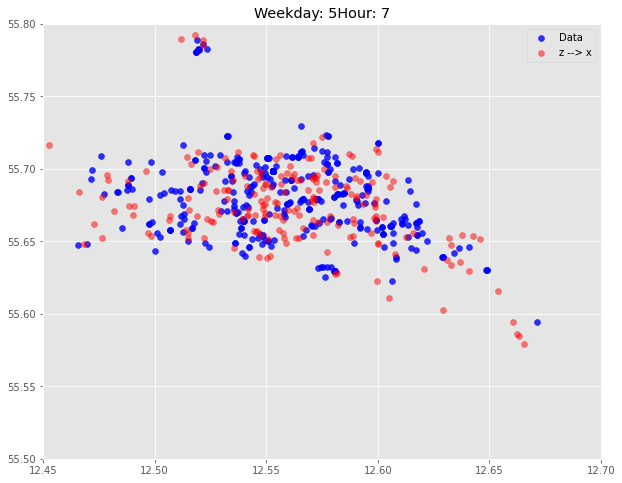

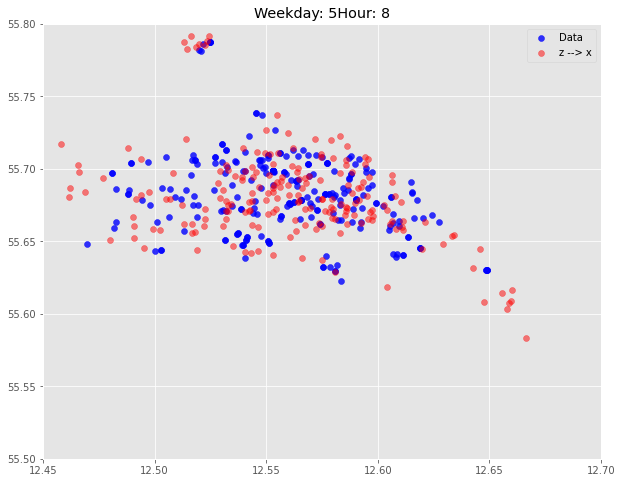

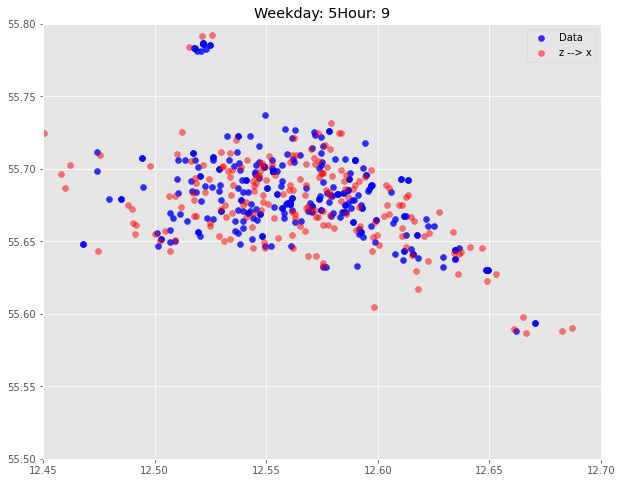

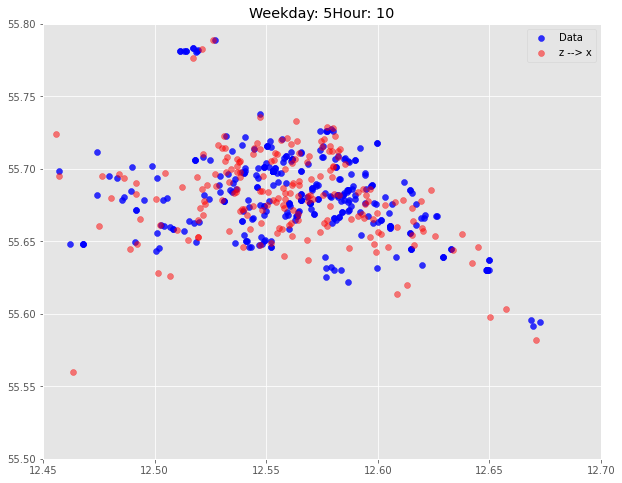

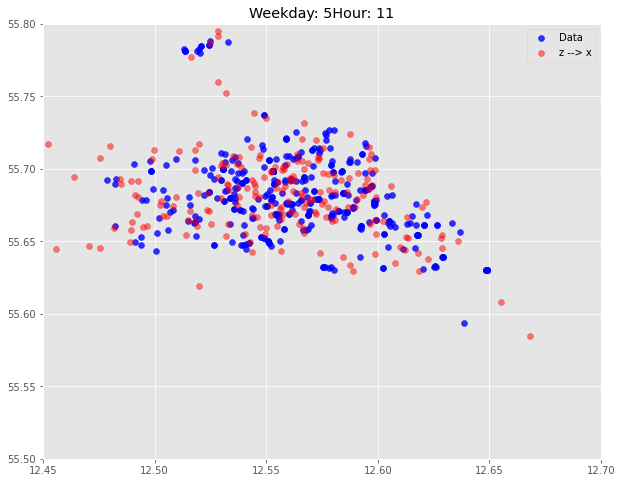

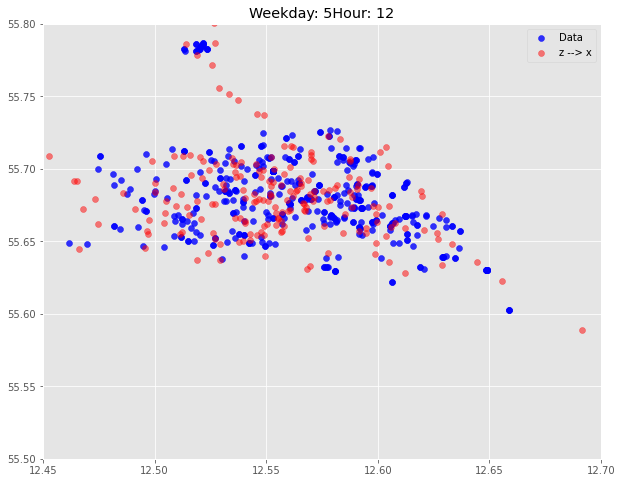

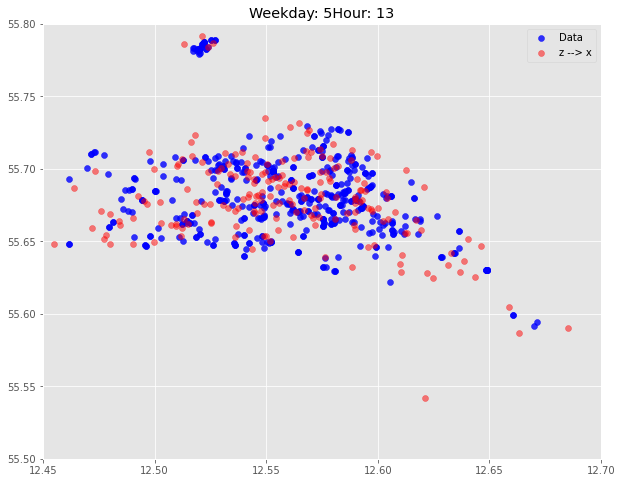

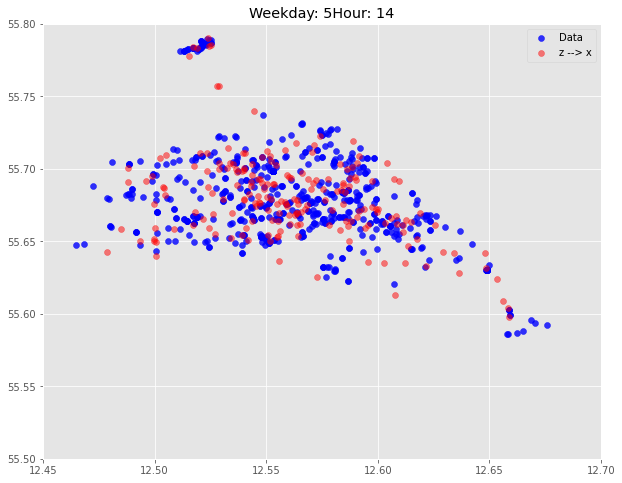

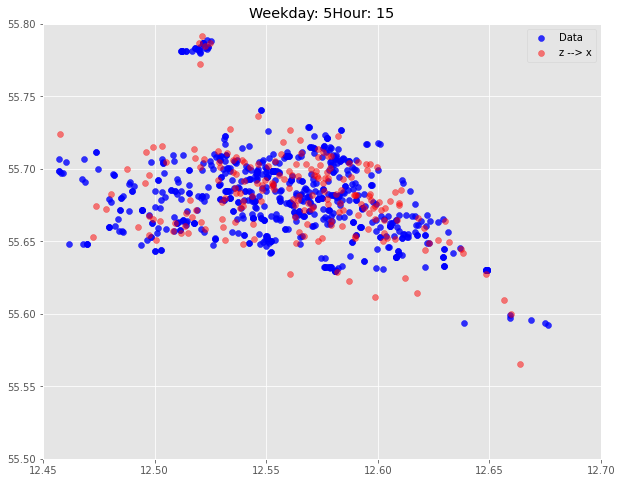

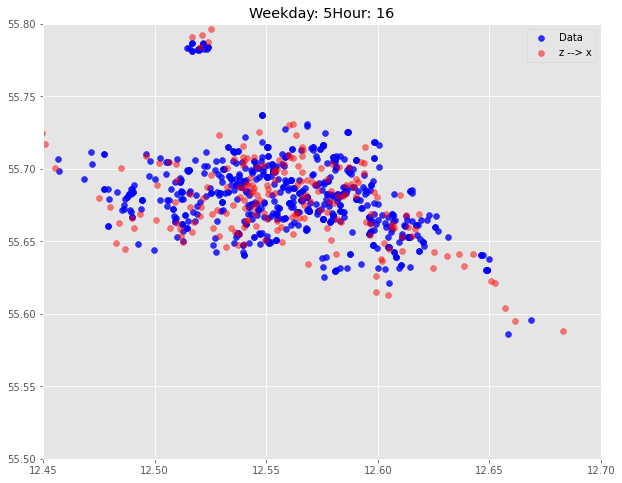

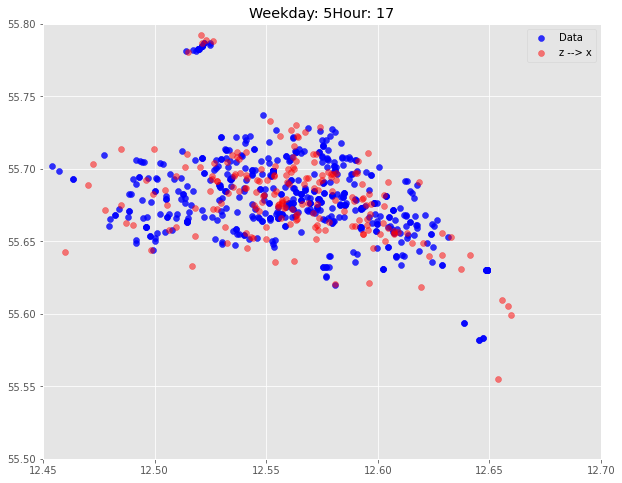

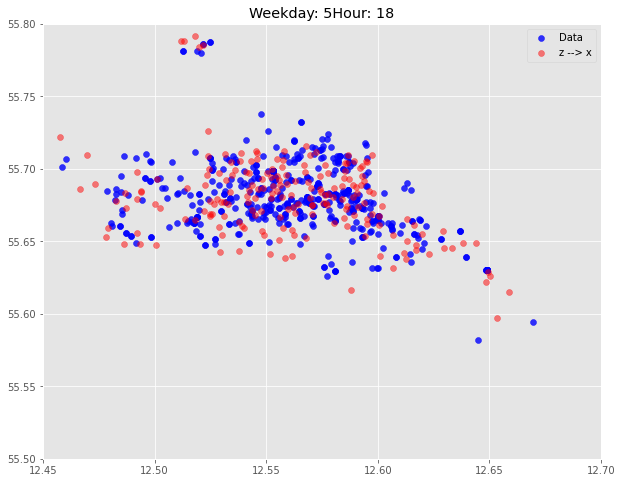

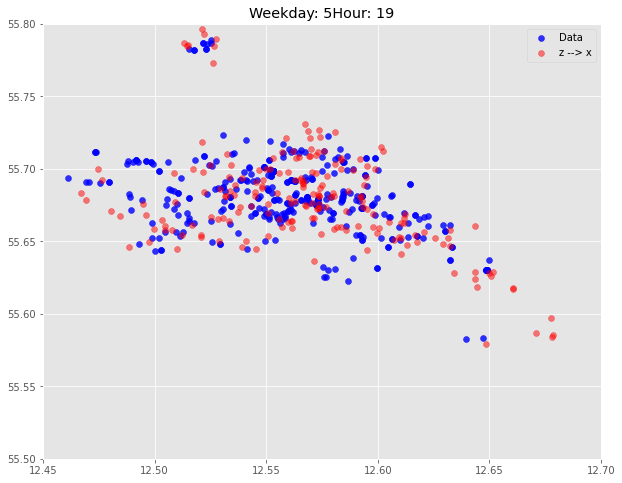

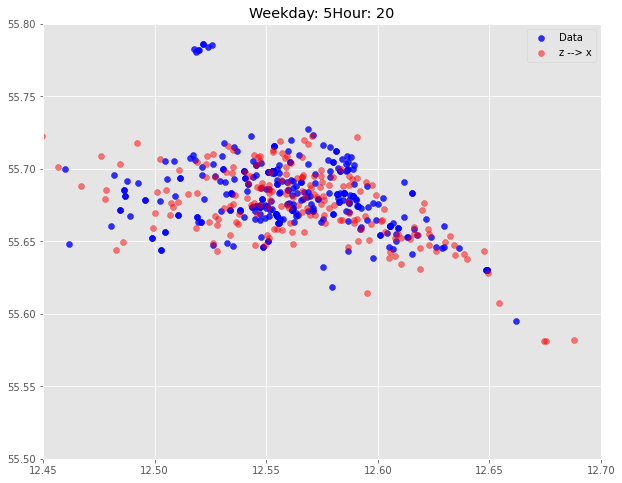

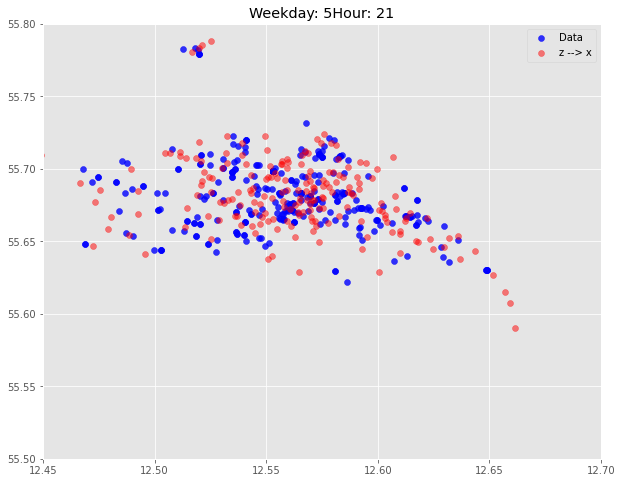

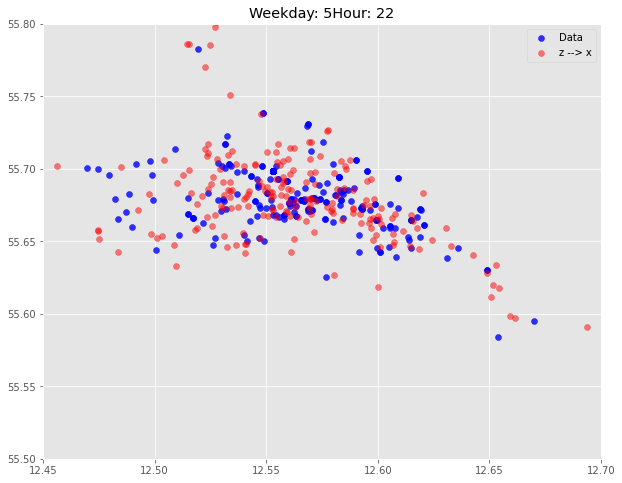

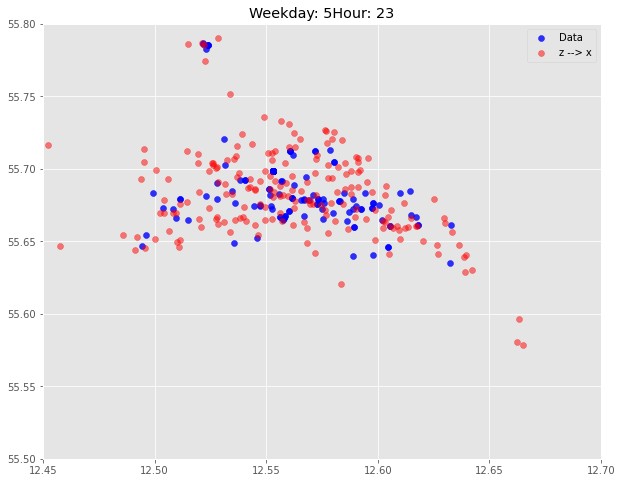

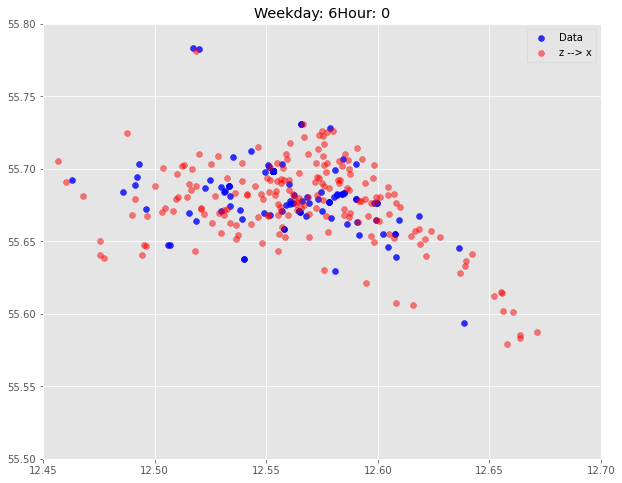

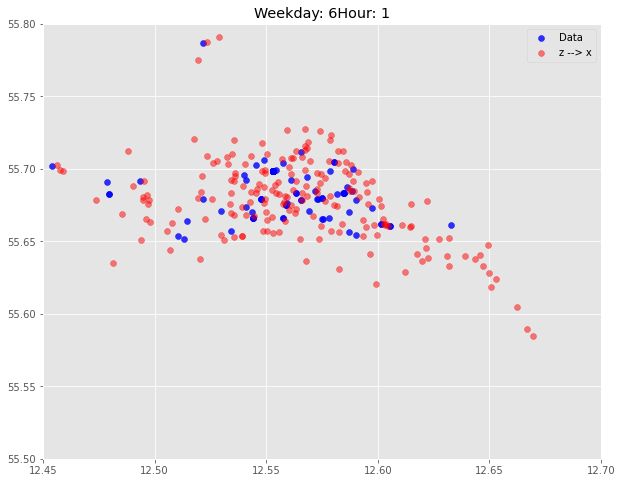

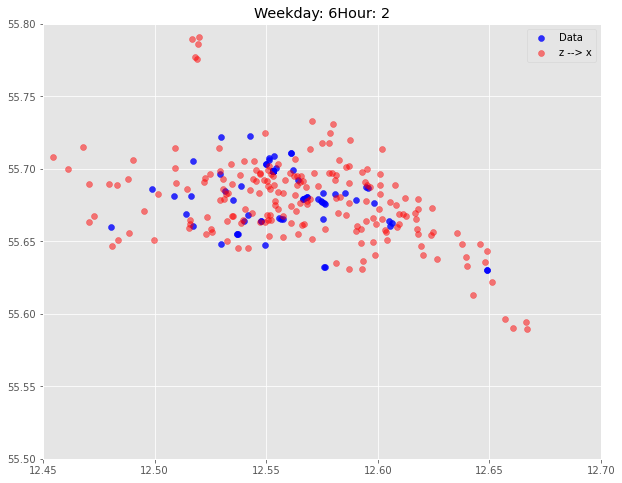

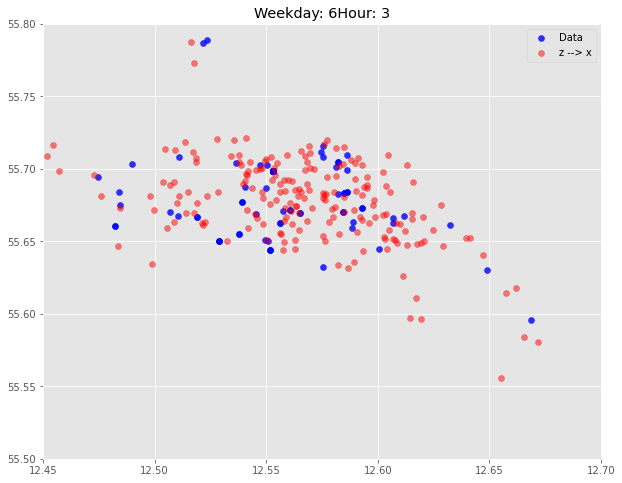

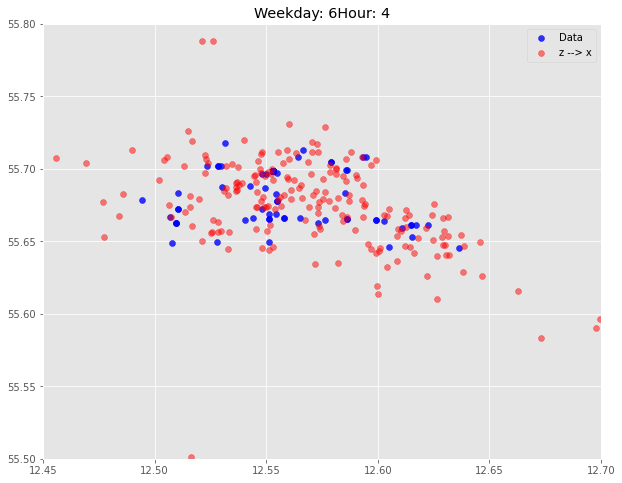

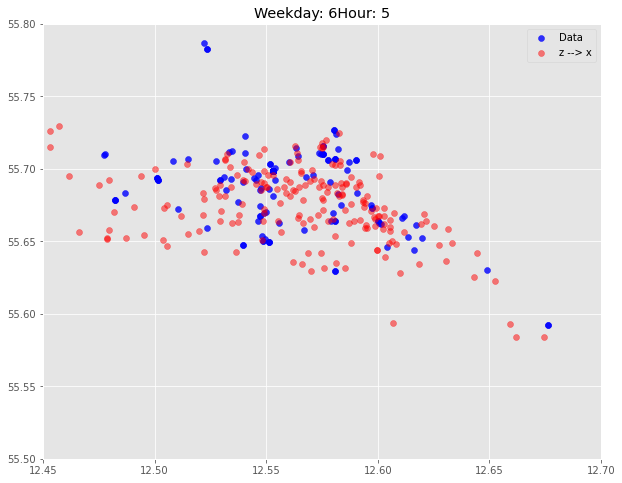

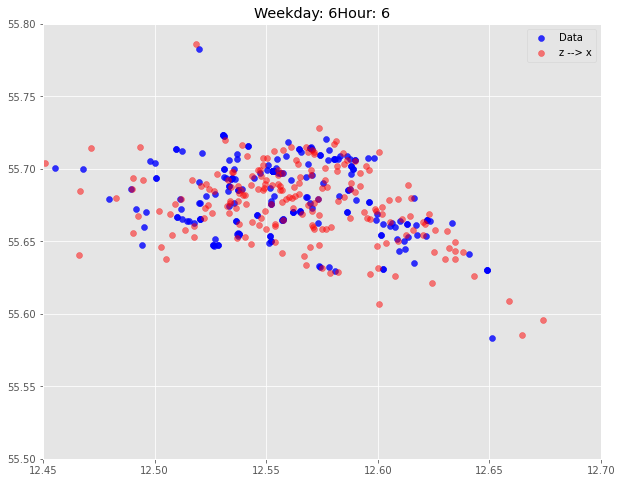

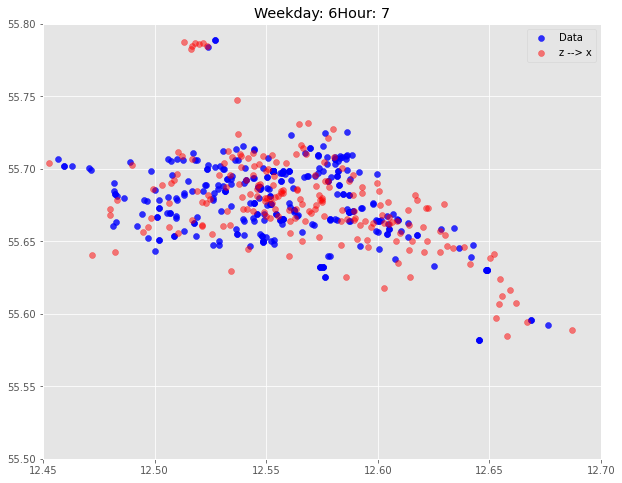

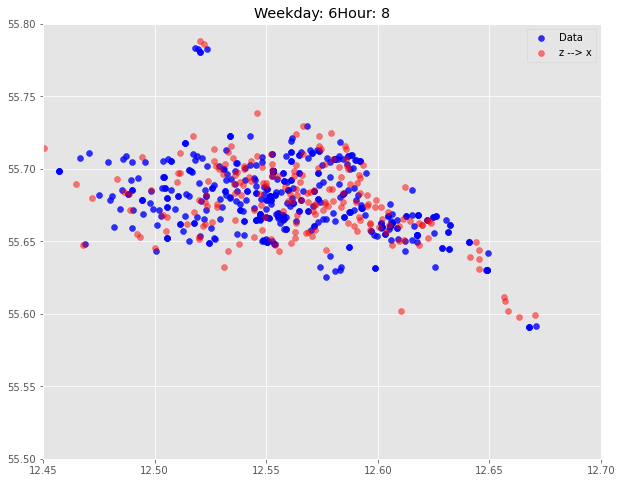

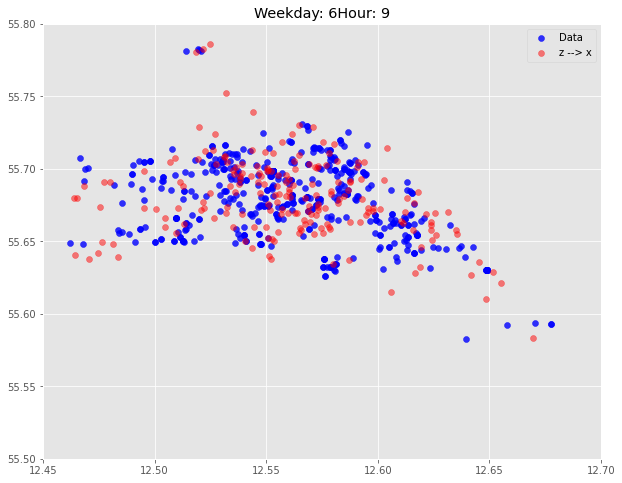

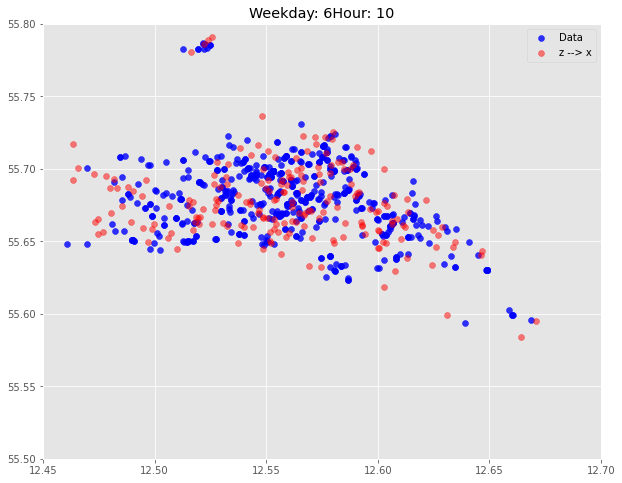

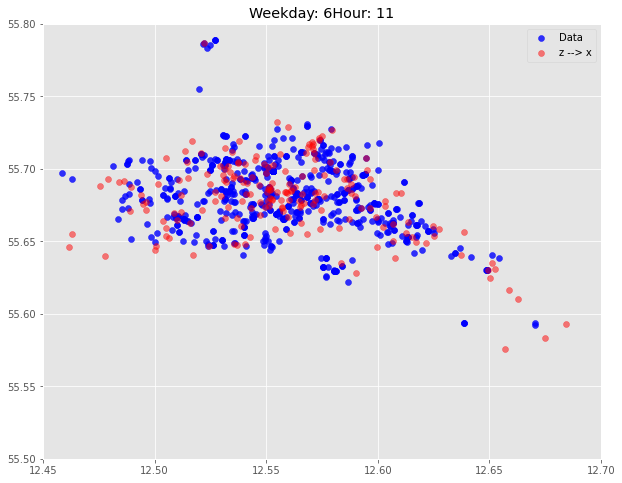

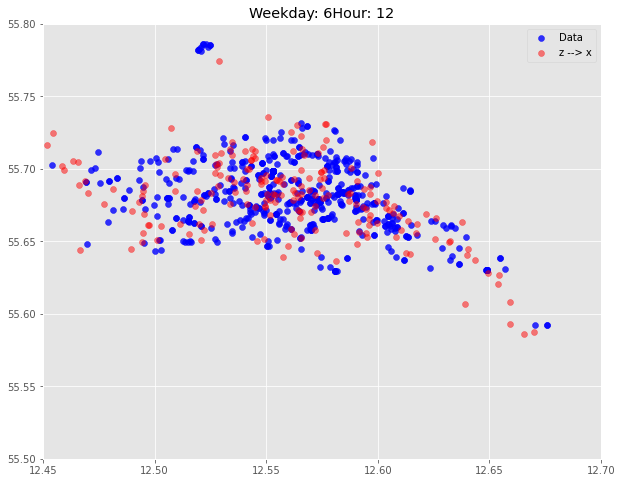

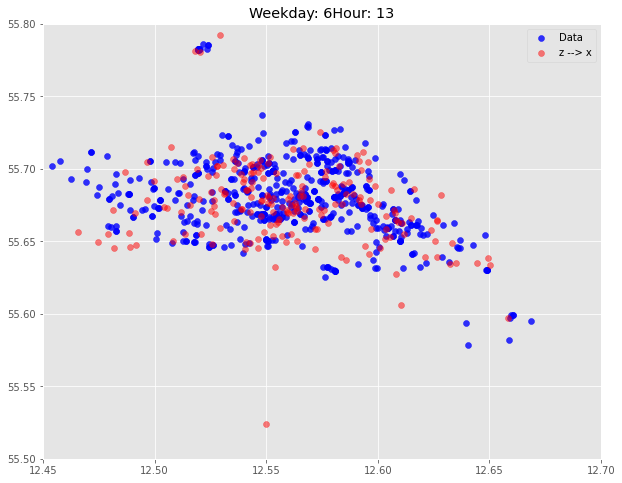

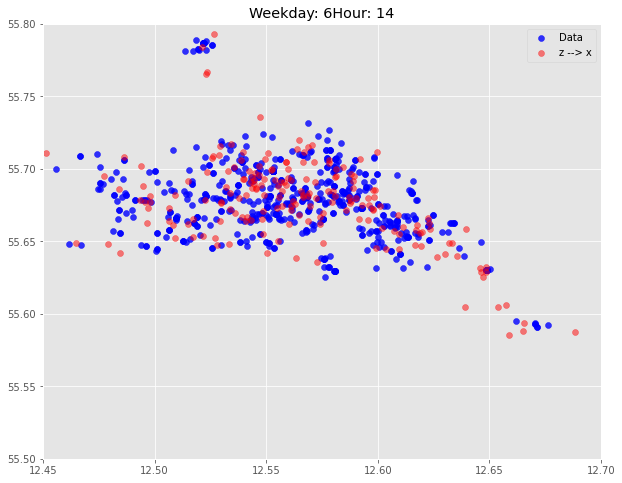

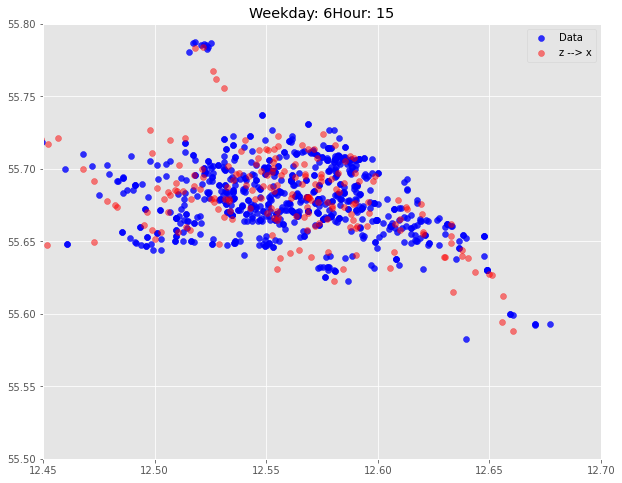

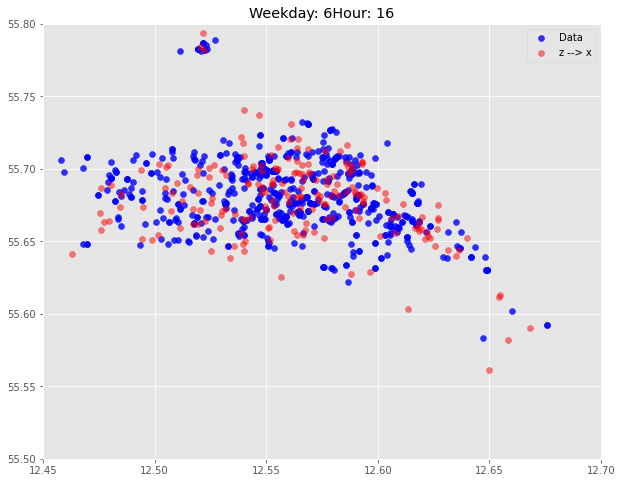

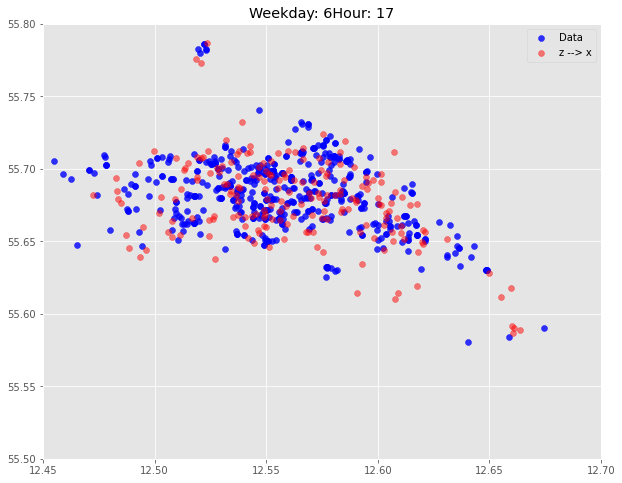

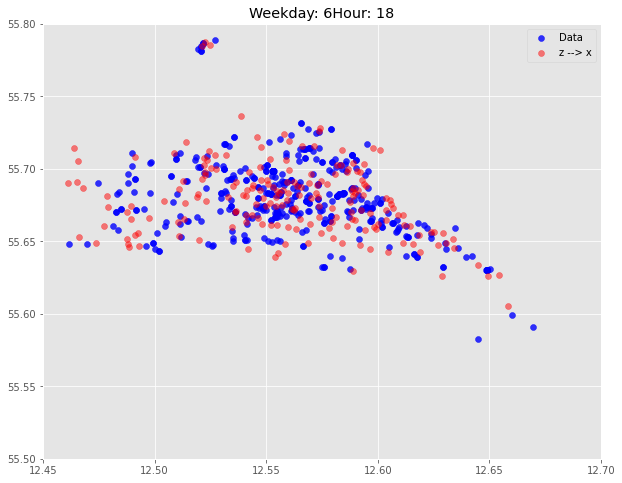

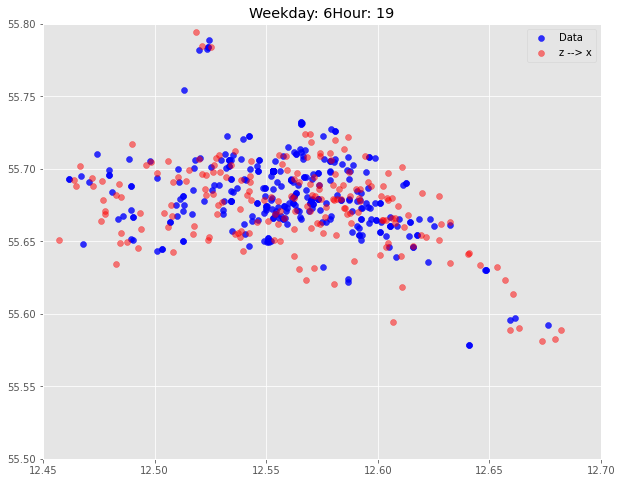

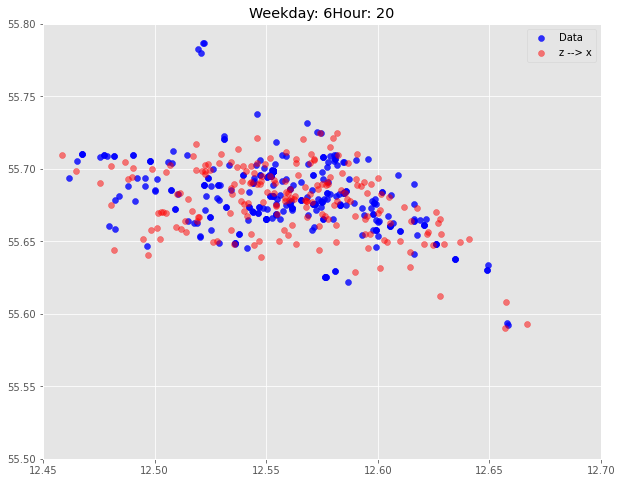

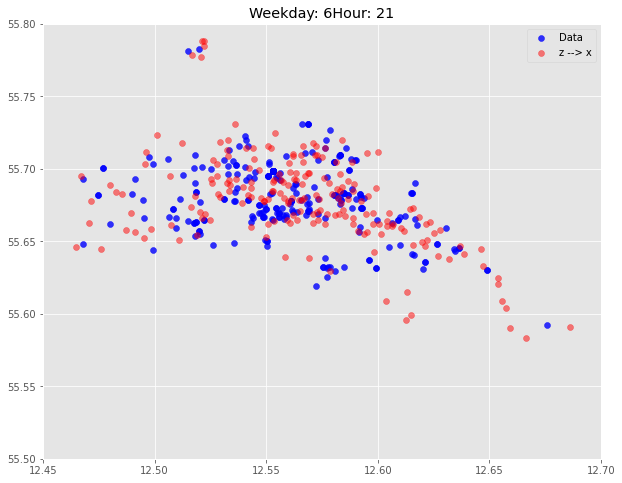

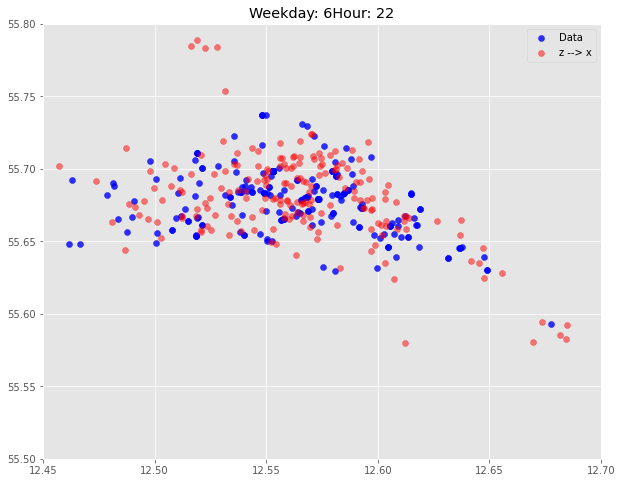

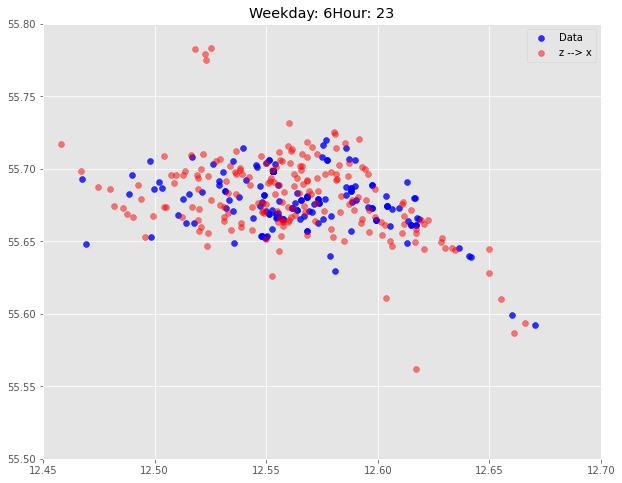

In [153]:
# Samples and data from time points
for i in range(7*24):
    if i%24 == 0:
        clear_output(wait=True)
    samples = cnf.sample(num_samples=200, H=torch.zeros(200,1)+i).detach()
    samples = (samples*sd + mean)
    idx = np.argwhere(np.asarray(H == i))
    fig = plt.figure(figsize=(10,8))
    plt.xlim(12.45, 12.7)
    plt.ylim(55.5, 55.8)
    plt.scatter(X_real[idx,1], X_real[idx,0], c="b", label="Data", alpha=0.8)
    plt.scatter(samples[:, 1], samples[:, 0], c="r", alpha=0.5, label="z --> x")
    plt.title('Weekday: {}'.format(i//24) + 'Hour: {}'.format(i%24))
    plt.legend()

In [ ]:
# Simulated densities
for i in range(7*24):
    samples = cnf.sample(num_samples=20000, H=torch.zeros(20000,1)+i).detach()
    samples1 = (samples*sd + mean)
    x, y = samples1[:, 1].numpy(), samples1[:, 0].numpy()
    clear_output(wait=True)
    plt.title('Weekday: {}'.format(i//24) + ' Hour: {}'.format(i%24))
    plt.hist2d(x, y, cmap=plt.cm.BuGn_r, bins = 100, range=[[12.45, 12.7], [55.5, 55.8]])
    plt.show()


In [ ]:
# Likelihoods and data
for i in range(24*7):
    idx = np.argwhere(np.asarray(H == i))
    x, y = X_H[idx, 1].numpy(), X_H[idx, 0].numpy() 
    a,b = torch.meshgrid([torch.arange(-6,6, step = 0.1), torch.arange(-9,6, step = 0.1)])
    grid2 = torch.cat([a.unsqueeze(-1), b.unsqueeze(-1)], dim = 2)
    df = cnf.log_prob(grid2, torch.zeros(1)+i)
    plt.figure(figsize=(15, 15))
    plt.scatter(x, y, c="orange", s=10)
    im = plt.imshow(df.detach().numpy(), origin="lower", interpolation="bicubic",
                    alpha=1, vmax=10., vmin=-10., cmap="inferno", extent=(-9, 6, -6, 6))
    plt.title('Weekday: {}'.format(i//24) + ' Hour: {}:00'.format(i%24))
    plt.xticks([])
    plt.yticks([])
    clear_output(wait=True)
    plt.show()

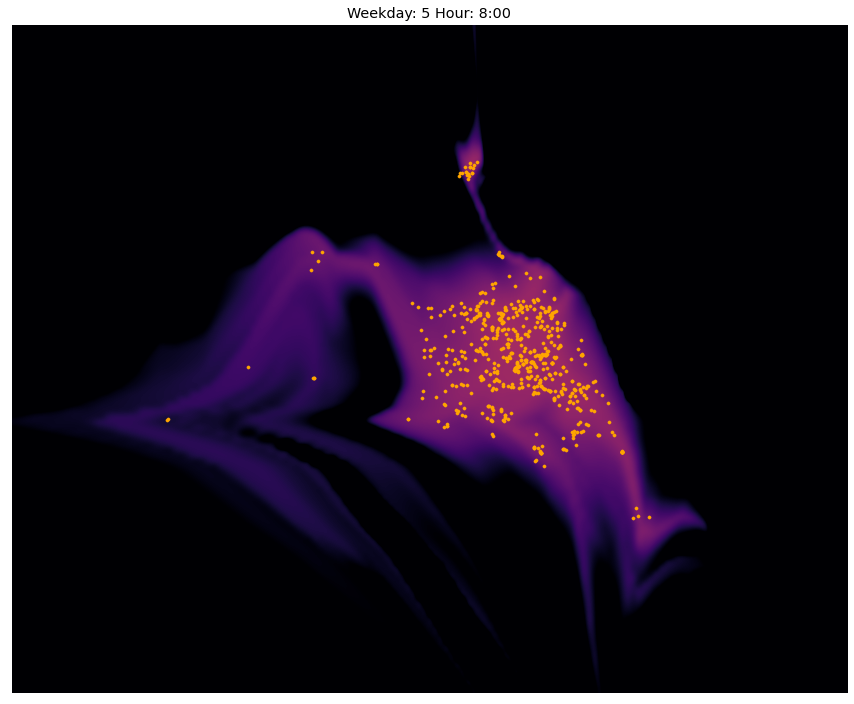

In [11]:
i = 128
idx = np.argwhere(np.asarray(data_tensor[:,3] == i))
x, y = ((data_tensor[idx, 2]-mean[1])/sd[1]).numpy(), ((data_tensor[idx, 1]-mean[0])/sd[0]).numpy()
a,b = torch.meshgrid([torch.arange(-6,6, step = 0.1), torch.arange(-9,6, step = 0.1)])
grid2 = torch.cat([a.unsqueeze(-1), b.unsqueeze(-1)], dim = 2)
df = cnf.log_prob(grid2, torch.zeros(1)+i)
plt.figure(figsize=(15, 15))
plt.scatter(x, y, c="orange", s=10)
im = plt.imshow(df.detach().numpy(), origin="lower", interpolation="bicubic",
                alpha=1, vmax=10., vmin=-10., cmap="inferno", extent=(-9, 6, -6, 6))
plt.title('Weekday: {}'.format(i//24) + ' Hour: {}:00'.format(i%24))
plt.xticks([])
plt.yticks([])
plt.savefig('results_5_8:00.pdf')
plt.show()

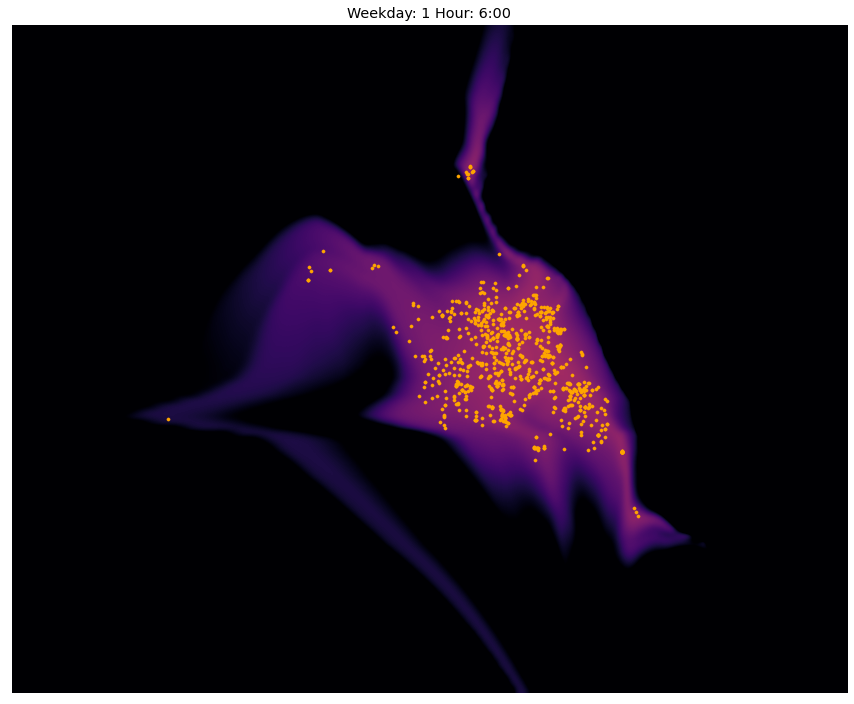

In [12]:
i = 30
idx = np.argwhere(np.asarray(data_tensor[:,3] == i))
x, y = ((data_tensor[idx, 2]-mean[1])/sd[1]).numpy(), ((data_tensor[idx, 1]-mean[0])/sd[0]).numpy()
a,b = torch.meshgrid([torch.arange(-6,6, step = 0.1), torch.arange(-9,6, step = 0.1)])
grid2 = torch.cat([a.unsqueeze(-1), b.unsqueeze(-1)], dim = 2)
df = cnf.log_prob(grid2, torch.zeros(1)+i)
plt.figure(figsize=(15, 15))
plt.scatter(x, y, c="orange", s=10)
im = plt.imshow(df.detach().numpy(), origin="lower", interpolation="bicubic",
                alpha=1, vmax=10., vmin=-10., cmap="inferno", extent=(-9, 6, -6, 6))
plt.title('Weekday: {}'.format(i//24) + ' Hour: {}:00'.format(i%24))
plt.xticks([])
plt.yticks([])
plt.savefig('results_1_6:00.pdf')
plt.show()

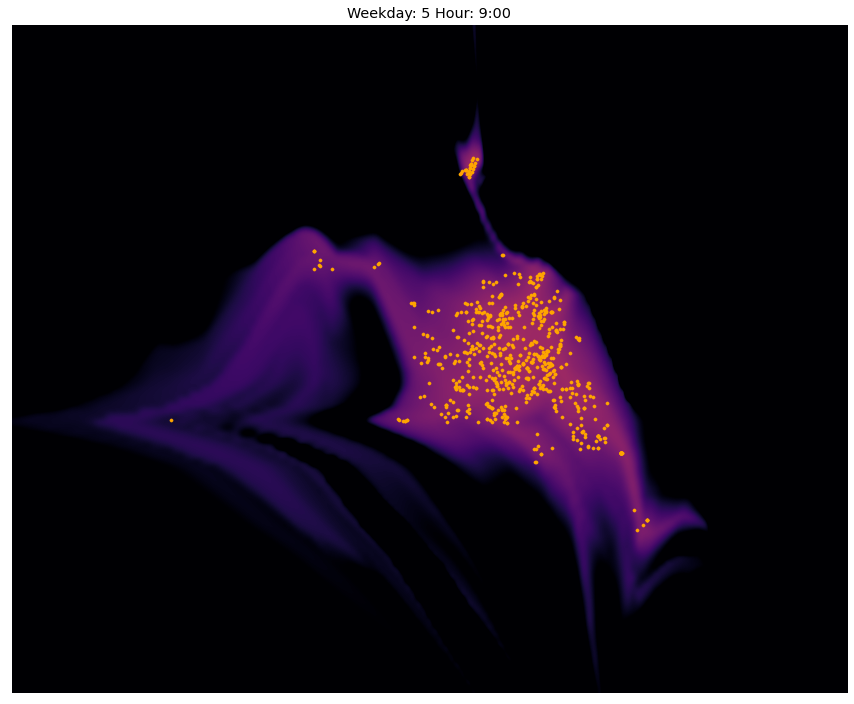

In [152]:
i = 129
idx = np.argwhere(np.asarray(data_tensor[:,3] == i))
x, y = ((data_tensor[idx, 2]-mean[1])/sd[1]).numpy(), ((data_tensor[idx, 1]-mean[0])/sd[0]).numpy()
a,b = torch.meshgrid([torch.arange(-6,6, step = 0.1), torch.arange(-9,6, step = 0.1)])
grid2 = torch.cat([a.unsqueeze(-1), b.unsqueeze(-1)], dim = 2)
df = cnf.log_prob(grid2, torch.zeros(1)+i)
plt.figure(figsize=(15, 15))
plt.scatter(x, y, c="orange", s=10)
im = plt.imshow(df.detach().numpy(), origin="lower", interpolation="bicubic",
                alpha=1, vmax=10., vmin=-10., cmap="inferno", extent=(-9, 6, -6, 6))
plt.title('Weekday: {}'.format(i//24) + ' Hour: {}:00'.format(i%24))
plt.xticks([])
plt.yticks([])
plt.show()